In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import os

## Aru maam-implementation, only RMS numerator and no noise term as well

# Implementing for all

In [5]:
def read_light_curve(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[1].data
        time = data['TIME']
        flux = data['RATE']
        flux_error = data['ERROR']  # Assuming the uncertainties are stored in a column named 'ERROR'
        ##Strictly for NICER format of timing
        hdr = hdul[1].header
        tstart = hdr['TSTART']
        mjdrefi = hdr['MJDREFI']
        mjdreff = hdr['MJDREFF']
        print("TSTART:", tstart)
    return time+tstart, flux, flux_error,tstart, mjdrefi+mjdreff

def compute_phases(time, period, epoch_mjd, tstart, mjdref):
    print("raw time value:", time[:10])
    absolute_time_mjd = mjdref + (tstart + time - 2.72) / 86400.0 ##Subtracting something to make phase, I dont know why it happens. 2.72 sec for 227
    delta_time_sec = (absolute_time_mjd - epoch_mjd) * 86400.0
    phases = (delta_time_sec % period) / period
    print("converted from reference epoch time: ",delta_time_sec[:10])
    return phases
   
def bin_data_by_phase(phases, flux, flux_error, num_bins):
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(phases, bin_edges) - 1
    phase_binned_flux = [flux[bin_indices == i] for i in range(num_bins)]
    phase_binned_flux_error = [flux_error[bin_indices == i] for i in range(num_bins)]
    return phase_binned_flux, phase_binned_flux_error

def compute_phase_resolved_rms(phase_binned_flux, phase_binned_flux_error, total_N):
    rms_values = []
    rms_errors = []

    for bin_flux, bin_flux_error in zip(phase_binned_flux, phase_binned_flux_error):
        if len(bin_flux) > 0:
            mean_flux = np.mean(bin_flux)
            squared_flux_deviation = (bin_flux - mean_flux) ** 2
            rms = np.sqrt(np.sum(squared_flux_deviation)/len(bin_flux))
            # Normalize RMS by sqrt(n), where n is total data in individual phase bins

            squared_error_deviation = squared_flux_deviation*(bin_flux_error ** 2)
            if rms!=0:
                rms_error = np.sqrt(np.sum(squared_error_deviation)) / (len(bin_flux)*rms)
            else: 
                rms_error=-1.0 ##dummy placeholder value.   
        else:
            rms = 0.0
            rms_error = 0.0

        rms_values.append(rms)
        rms_errors.append(rms_error)

    return np.array(rms_values), np.array(rms_errors)

def main(input_file):
    # Load the text file data using pandas
    df = pd.read_csv(input_file, delimiter='\t',comment="#")
    df = df[df['Period'] != "-none-"]
    df['Period'] = df['Period'].astype(float)
    df['LC_File_Path'] = df['LC_File_Path'].astype(str)
    
    num_bins = 64  # Number of phase bins
    epoch_mjd = 60112.43540056619  # Reference epoch in MJD

    for index, row in df.iterrows():
        file_path = row['LC_File_Path']
        period = row['Period']

        try:
            time, flux, flux_error,tstart,mjdref = read_light_curve(f'./reduced_output/{file_path}/ni{file_path}_cl_nightmpu7_sr_night_barycorr_orbit_gti_0.05.lc')
            if len(time) == 0 or len(flux) == 0:
                print(f"No data found in file: {file_path}. Skipping this file.")
                continue  # Skip to the next iteration if the data is empty

            total_duration = time.max() - time.min()
            num_periods = total_duration / period
            total_N = int(num_periods * 64)  # Total bins considering 64 bins per period

            print(f"Processing file: {file_path}")
            print(f"First event time: {time.min()}")
            print(f"Last event time: {time.max()}")
            print(f"Total duration: {time.max() - time.min()} seconds")


            mean_flux_over_observation = np.mean(flux)  # Compute mean flux over the entire observation
   
            phases = compute_phases(time, period, epoch_mjd, tstart, mjdref)
            phase_binned_flux, phase_binned_flux_error = bin_data_by_phase(phases, flux, flux_error, num_bins)
            rms_values, rms_errors = compute_phase_resolved_rms(phase_binned_flux, phase_binned_flux_error, total_N)
            mid_phase = (np.linspace(0, 1, num_bins + 1)[:-1] + np.linspace(0, 1, num_bins + 1)[1:]) / 2
        
            # Compute RMS / Mean Flux
            rms_over_mean_flux = rms_values / mean_flux_over_observation
            rms_error_over_mean_flux = rms_errors / mean_flux_over_observation
        
            # Compute Phase-Resolved Flux Values
            # Prepare data for plotting flux 2 cycles
            avg_flux = [np.mean(bin_flux) if len(bin_flux) > 0 else 0 for bin_flux in phase_binned_flux]
            avg_flux_2x = np.concatenate((avg_flux, avg_flux))
            avg_flux_error = [np.sqrt(np.sum(bin_flux_error**2)) / len(bin_flux_error) if len(bin_flux_error) > 0 else 0 for bin_flux_error in phase_binned_flux_error]
            avg_flux_error_2x = np.concatenate((avg_flux_error, avg_flux_error))


            # Prepare data for plotting 2 cycles
            mid_phase_2x = (np.linspace(0, 2, num_bins * 2 + 1)[:-1] + np.linspace(0, 2, num_bins * 2 + 1)[1:]) / 2
            rms_values_2x = np.concatenate((rms_values, rms_values))
            rms_errors_2x = np.concatenate((rms_errors, rms_errors))

            #Prepare the folder if it does not exit. 
            os.makedirs(f'./folded_curves/{file_path}', exist_ok=True)  # Create main output folder if not exists

            # Step 6: Plot the phase-resolved RMS
            plt.figure(figsize=(12, 5))
            plt.errorbar(mid_phase_2x, 100*rms_values_2x/avg_flux_2x, yerr=100*rms_errors_2x/avg_flux_2x, fmt='-o')
            plt.xlabel('Phase')
            plt.ylabel('RMS')
            plt.title(f'Phase-resolved RMS for {file_path}')
            plt.grid()
            plt.savefig(f'./folded_curves/{file_path}/{file_path}_rms_curve_maam_code.png')
            plt.show()

            # Step 7: Save the results to a FITS file
            col1 = fits.Column(name='PHASE', format='E', array=mid_phase)
            col2 = fits.Column(name='RMS', format='E', array=rms_values)
            col3 = fits.Column(name='RMS_ERROR', format='E', array=rms_errors)
            col4 = fits.Column(name='RMS_OVER_MEAN_FLUX', format='E', array=rms_over_mean_flux)
            col5 = fits.Column(name='RMS_ERROR_OVER_MEAN_FLUX', format='E', array=rms_error_over_mean_flux)
            col6 = fits.Column(name='AVG_FLUX', format='E', array=avg_flux)
            col7 = fits.Column(name='AVG_FLUX_ERROR', format='E', array=avg_flux_error)
            hdu = fits.BinTableHDU.from_columns([col1, col2, col3, col4, col5, col6, col7])
            hdu.writeto(f'./folded_curves/{file_path}/{file_path}_rms_deviation_flux_errors.fits', overwrite=True)

            # Plot the phase-resolved flux
            plt.figure(figsize=(12, 5))
            plt.errorbar(mid_phase_2x, avg_flux_2x, yerr=avg_flux_error_2x, fmt='-o')
            plt.xlabel('Phase')
            plt.ylabel('Flux')
            plt.grid()
            plt.title(f'Phase-resolved Flux for {file_path}')
            plt.savefig(f'./folded_curves/{file_path}/{file_path}_pulse_profile_maam_code.png')
            plt.show()

            
        except Exception as e:
            print(f"An error occurred while processing {file_path}: {e}")

TSTART: 298463040.0
Processing file: 6050390227
First event time: 298463040.0
Last event time: 298496735.95
Total duration: 33695.94999998808 seconds
raw time value: [2.9846304e+08 2.9846304e+08 2.9846304e+08 2.9846304e+08 2.9846304e+08
 2.9846304e+08 2.9846304e+08 2.9846304e+08 2.9846304e+08 2.9846304e+08]
converted from reference epoch time:  [2.98462926e+08 2.98462926e+08 2.98462926e+08 2.98462926e+08
 2.98462926e+08 2.98462926e+08 2.98462926e+08 2.98462926e+08
 2.98462926e+08 2.98462926e+08]


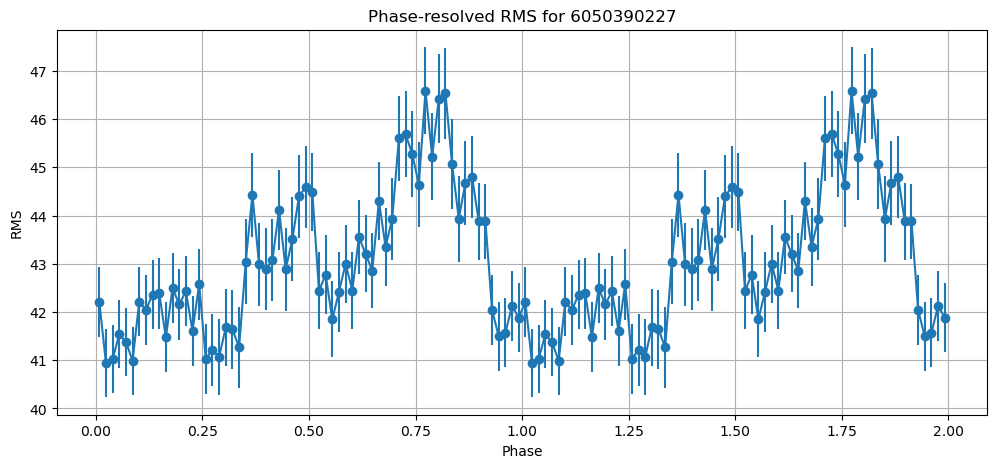

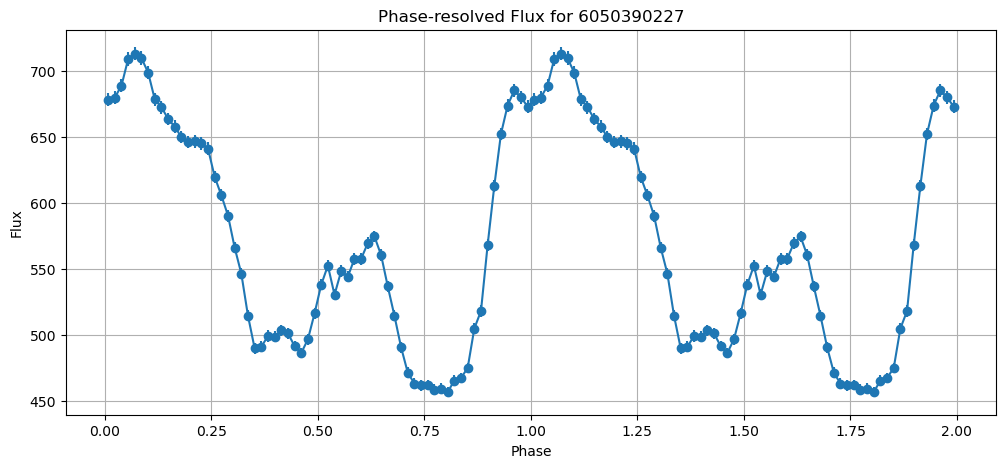

TSTART: 298574496.0
Processing file: 6050390228
First event time: 298574496.0
Last event time: 298597151.95
Total duration: 22655.94999998808 seconds
raw time value: [2.98574496e+08 2.98574496e+08 2.98574496e+08 2.98574496e+08
 2.98574496e+08 2.98574496e+08 2.98574496e+08 2.98574496e+08
 2.98574496e+08 2.98574496e+08]
converted from reference epoch time:  [2.98685838e+08 2.98685838e+08 2.98685838e+08 2.98685838e+08
 2.98685838e+08 2.98685838e+08 2.98685838e+08 2.98685838e+08
 2.98685838e+08 2.98685838e+08]


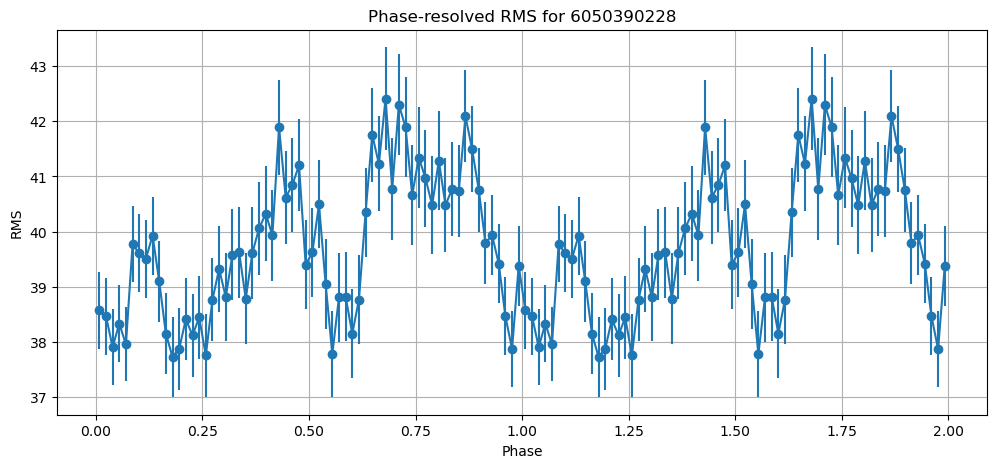

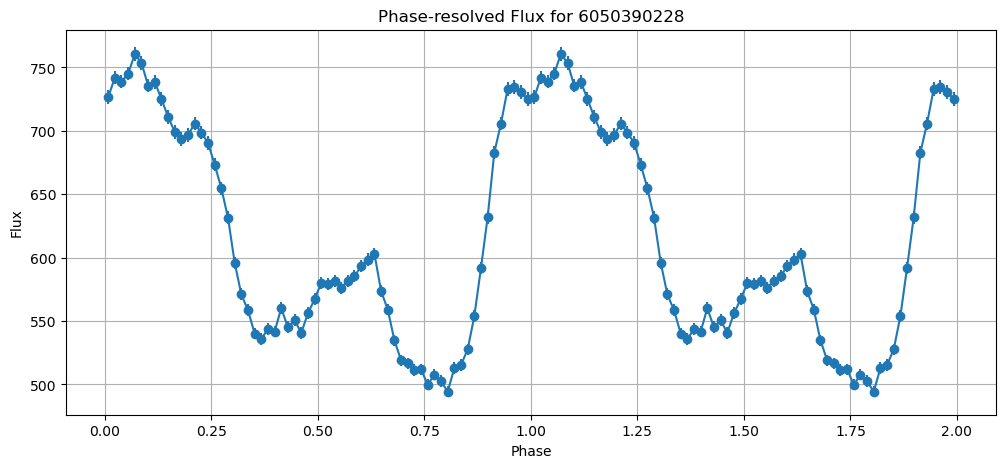

TSTART: 298602368.0
Processing file: 6050390229
First event time: 298602368.0
Last event time: 298675199.95
Total duration: 72831.94999998808 seconds
raw time value: [2.98602368e+08 2.98602368e+08 2.98602368e+08 2.98602368e+08
 2.98602368e+08 2.98602368e+08 2.98602368e+08 2.98602368e+08
 2.98602368e+08 2.98602368e+08]
converted from reference epoch time:  [2.98741582e+08 2.98741582e+08 2.98741582e+08 2.98741582e+08
 2.98741582e+08 2.98741582e+08 2.98741582e+08 2.98741582e+08
 2.98741582e+08 2.98741582e+08]


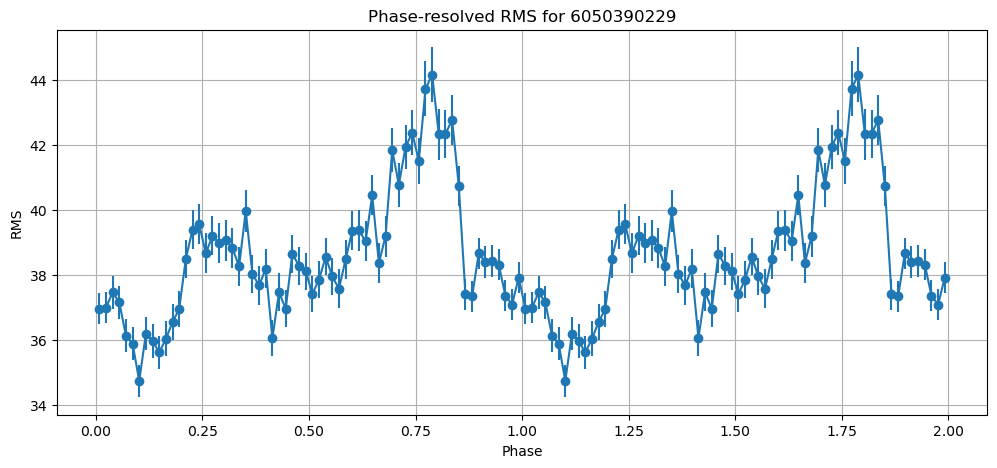

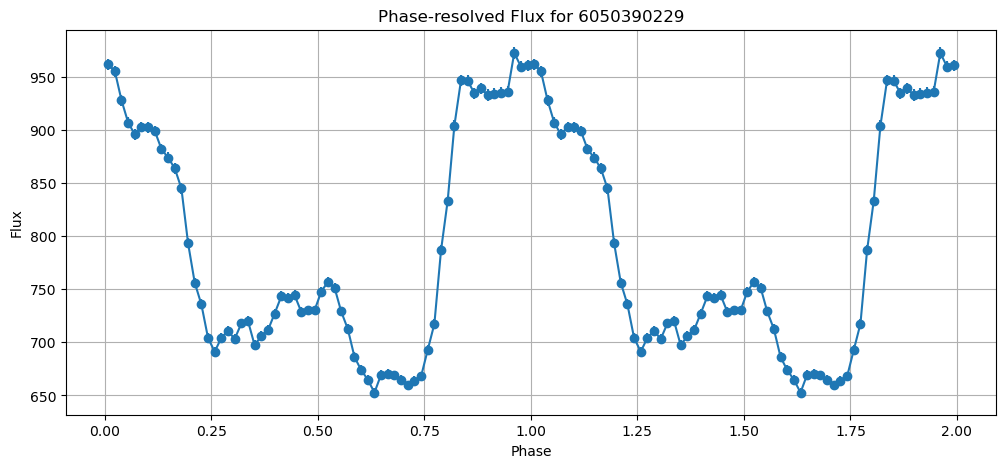

TSTART: 298747296.0
Processing file: 6050390230
First event time: 298747296.0
Last event time: 298764415.95
Total duration: 17119.94999998808 seconds
raw time value: [2.98747296e+08 2.98747296e+08 2.98747296e+08 2.98747296e+08
 2.98747296e+08 2.98747296e+08 2.98747296e+08 2.98747296e+08
 2.98747296e+08 2.98747296e+08]
converted from reference epoch time:  [2.99031438e+08 2.99031438e+08 2.99031438e+08 2.99031438e+08
 2.99031438e+08 2.99031438e+08 2.99031438e+08 2.99031438e+08
 2.99031438e+08 2.99031438e+08]


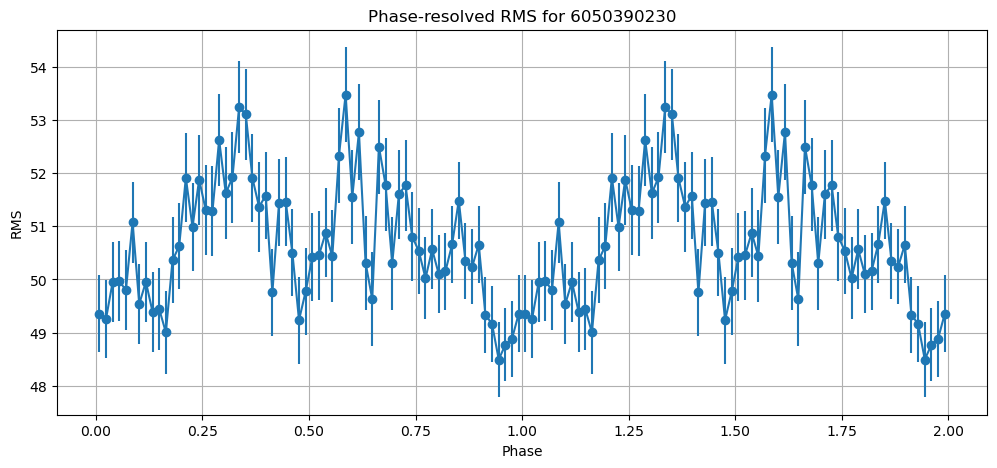

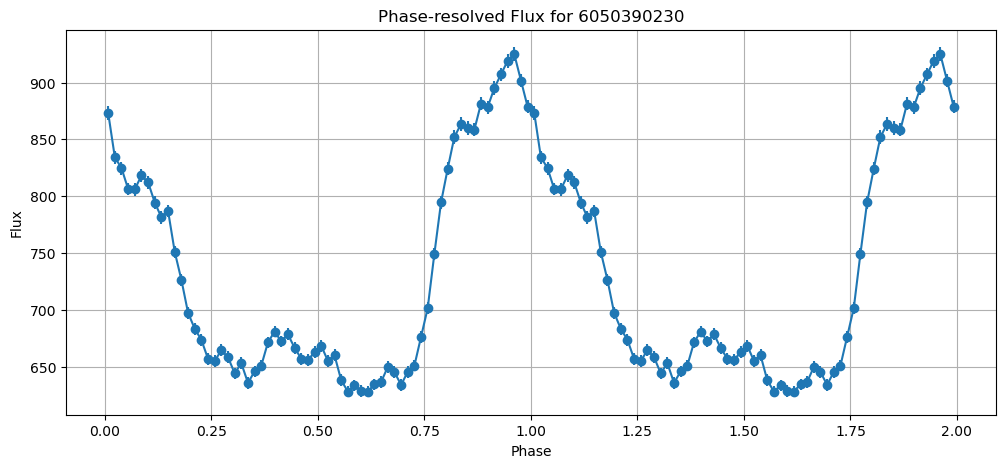

TSTART: 298831104.0
Processing file: 6050390231
First event time: 298831104.0
Last event time: 298853631.95
Total duration: 22527.94999998808 seconds
raw time value: [2.98831104e+08 2.98831104e+08 2.98831104e+08 2.98831104e+08
 2.98831104e+08 2.98831104e+08 2.98831104e+08 2.98831104e+08
 2.98831104e+08 2.98831104e+08]
converted from reference epoch time:  [2.99199054e+08 2.99199054e+08 2.99199054e+08 2.99199054e+08
 2.99199054e+08 2.99199054e+08 2.99199054e+08 2.99199054e+08
 2.99199054e+08 2.99199054e+08]


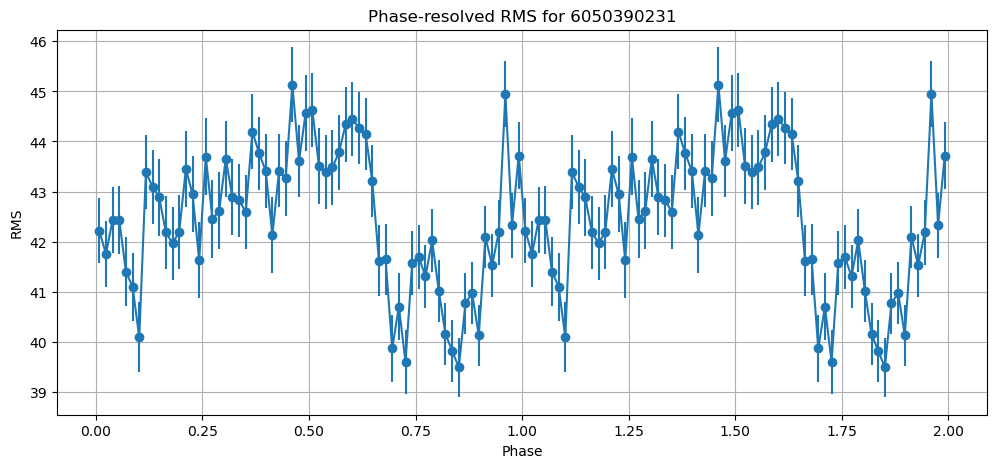

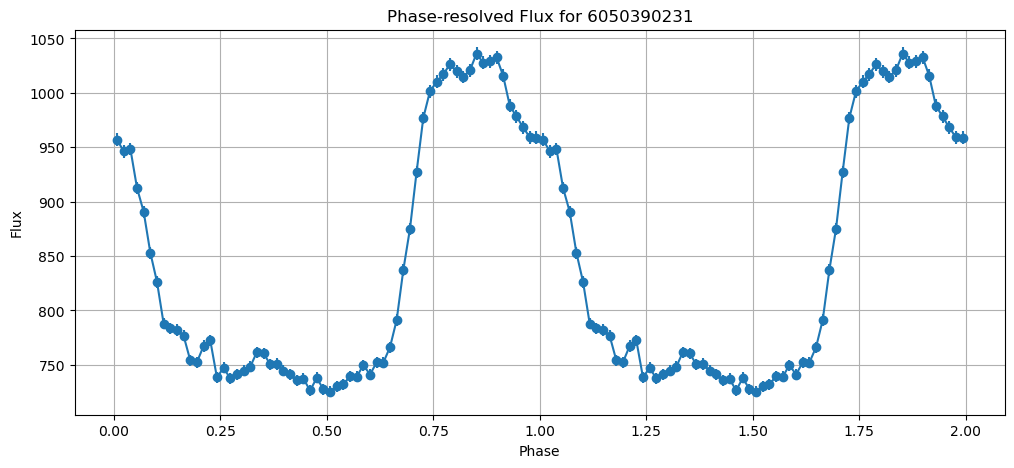

TSTART: 298858912.0
Processing file: 6050390232
First event time: 298858912.0
Last event time: 298942847.95
Total duration: 83935.94999998808 seconds
raw time value: [2.98858912e+08 2.98858912e+08 2.98858912e+08 2.98858912e+08
 2.98858912e+08 2.98858912e+08 2.98858912e+08 2.98858912e+08
 2.98858912e+08 2.98858912e+08]
converted from reference epoch time:  [2.9925467e+08 2.9925467e+08 2.9925467e+08 2.9925467e+08 2.9925467e+08
 2.9925467e+08 2.9925467e+08 2.9925467e+08 2.9925467e+08 2.9925467e+08]


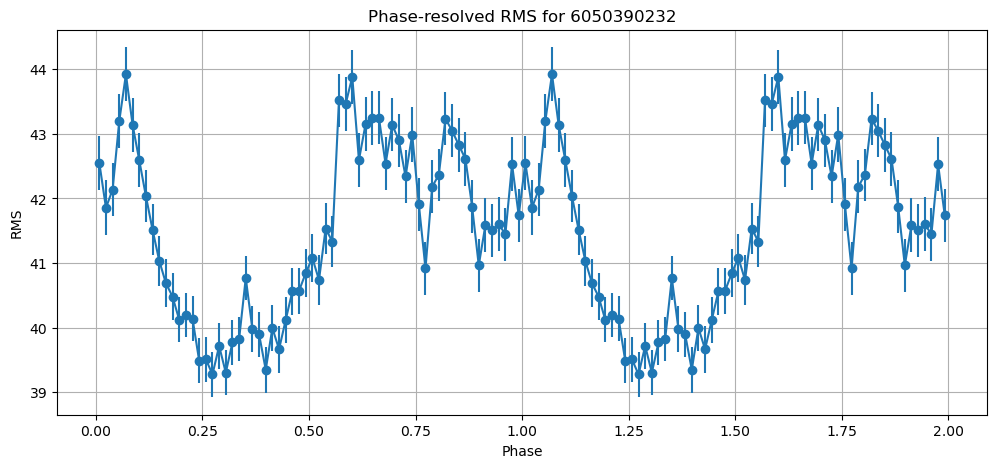

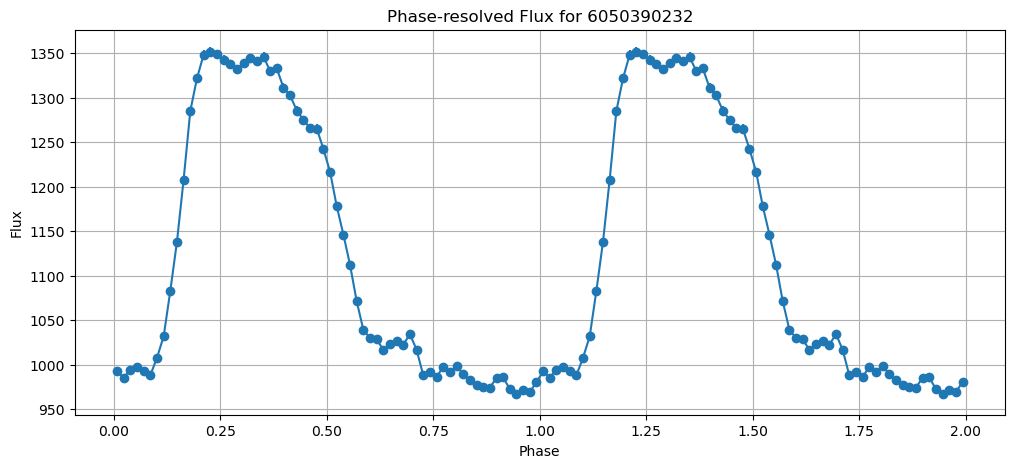

TSTART: 298953504.0
Processing file: 6050390233
First event time: 298953504.0
Last event time: 299026463.95
Total duration: 72959.94999998808 seconds
raw time value: [2.98953504e+08 2.98953504e+08 2.98953504e+08 2.98953504e+08
 2.98953504e+08 2.98953504e+08 2.98953504e+08 2.98953504e+08
 2.98953504e+08 2.98953504e+08]
converted from reference epoch time:  [2.99443854e+08 2.99443854e+08 2.99443854e+08 2.99443854e+08
 2.99443854e+08 2.99443854e+08 2.99443854e+08 2.99443854e+08
 2.99443854e+08 2.99443854e+08]


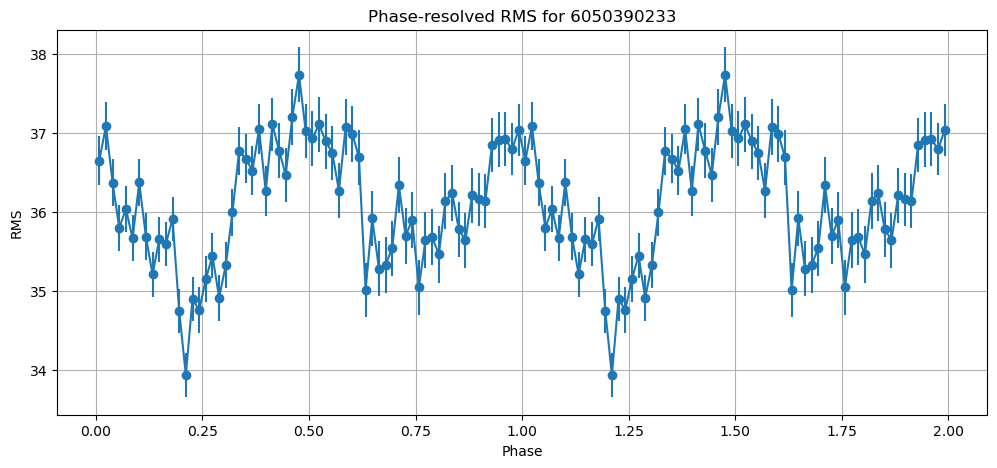

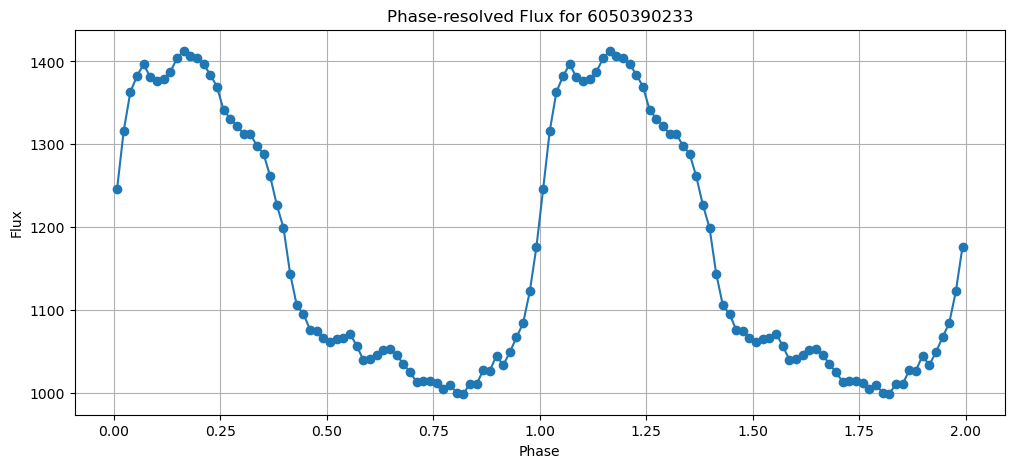

TSTART: 299031552.0
Processing file: 6050390234
First event time: 299031552.0
Last event time: 299093375.95
Total duration: 61823.94999998808 seconds
raw time value: [2.99031552e+08 2.99031552e+08 2.99031552e+08 2.99031552e+08
 2.99031552e+08 2.99031552e+08 2.99031552e+08 2.99031552e+08
 2.99031552e+08 2.99031552e+08]
converted from reference epoch time:  [2.9959995e+08 2.9959995e+08 2.9959995e+08 2.9959995e+08 2.9959995e+08
 2.9959995e+08 2.9959995e+08 2.9959995e+08 2.9959995e+08 2.9959995e+08]


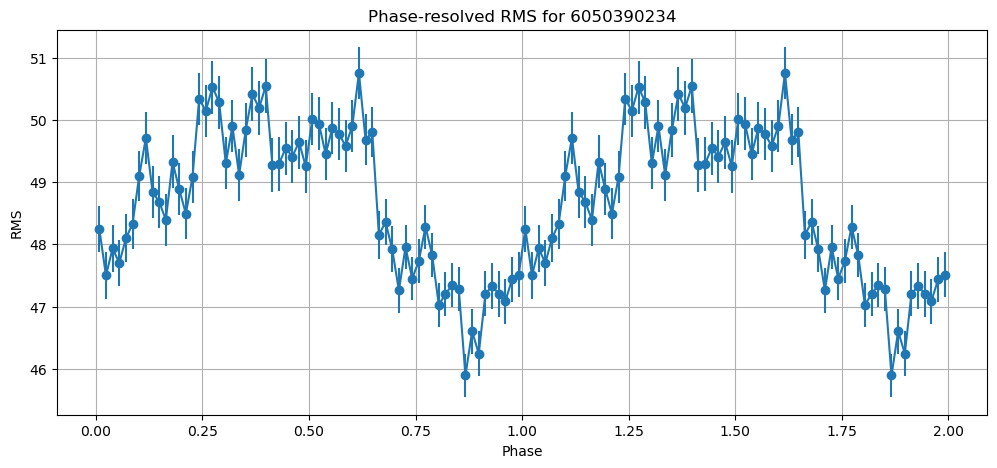

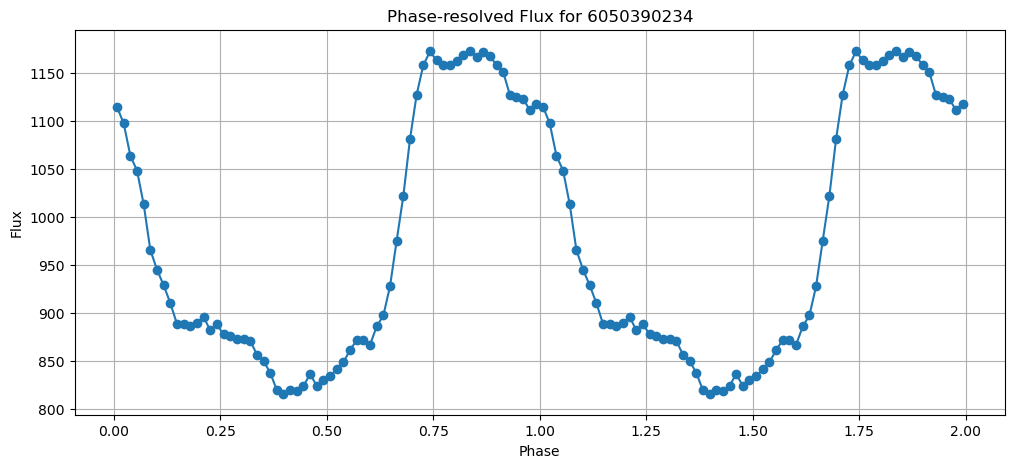

TSTART: 299120736.0
Processing file: 6050390235
First event time: 299120736.0
Last event time: 299188127.95
Total duration: 67391.94999998808 seconds
raw time value: [2.99120736e+08 2.99120736e+08 2.99120736e+08 2.99120736e+08
 2.99120736e+08 2.99120736e+08 2.99120736e+08 2.99120736e+08
 2.99120736e+08 2.99120736e+08]
converted from reference epoch time:  [2.99778318e+08 2.99778318e+08 2.99778318e+08 2.99778318e+08
 2.99778318e+08 2.99778318e+08 2.99778318e+08 2.99778318e+08
 2.99778318e+08 2.99778318e+08]


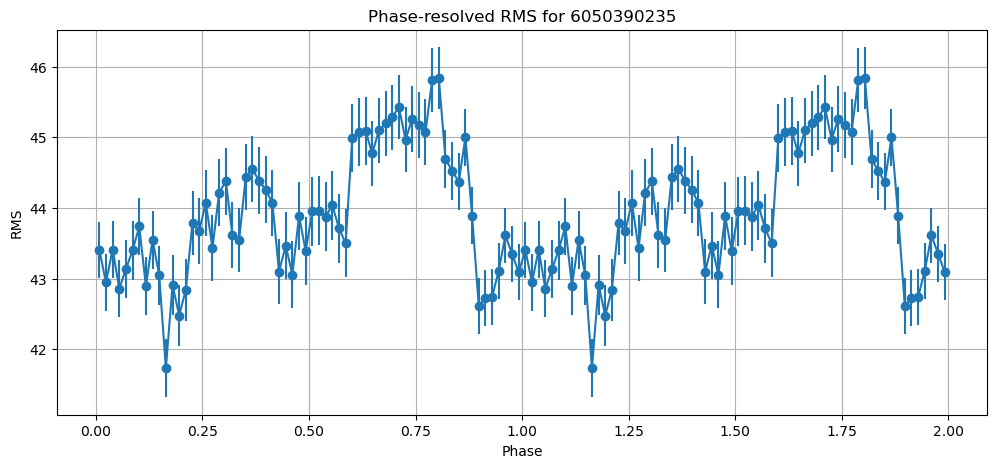

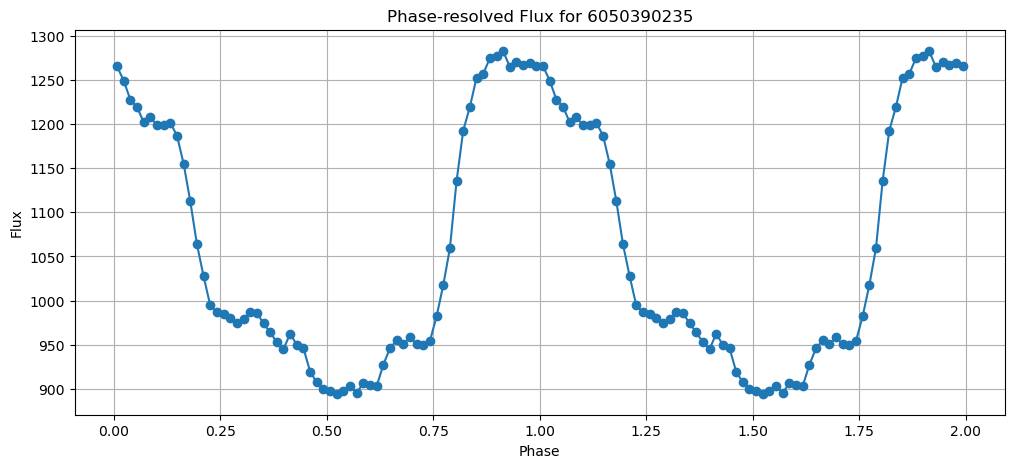

TSTART: 299271136.0
Processing file: 6050390236
First event time: 299271136.0
Last event time: 299288447.95
Total duration: 17311.94999998808 seconds
raw time value: [2.99271136e+08 2.99271136e+08 2.99271136e+08 2.99271136e+08
 2.99271136e+08 2.99271136e+08 2.99271136e+08 2.99271136e+08
 2.99271136e+08 2.99271136e+08]
converted from reference epoch time:  [3.00079118e+08 3.00079118e+08 3.00079118e+08 3.00079118e+08
 3.00079118e+08 3.00079118e+08 3.00079118e+08 3.00079118e+08
 3.00079118e+08 3.00079118e+08]


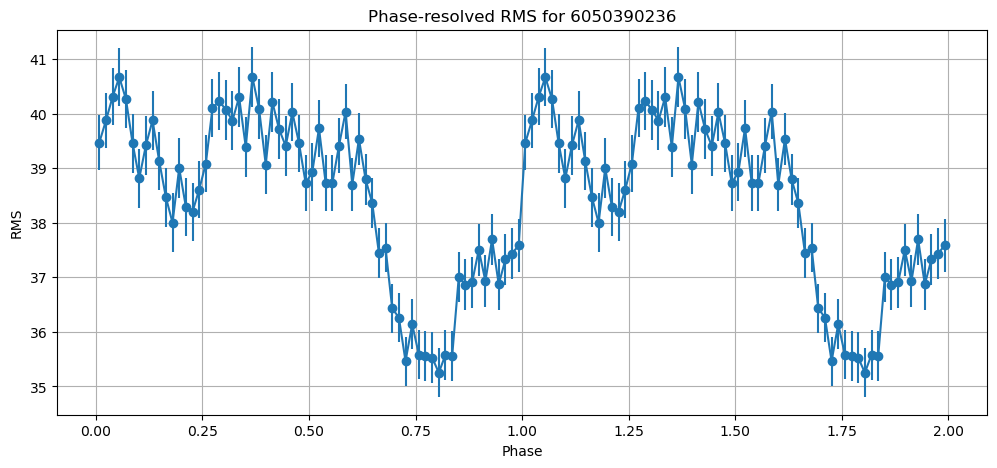

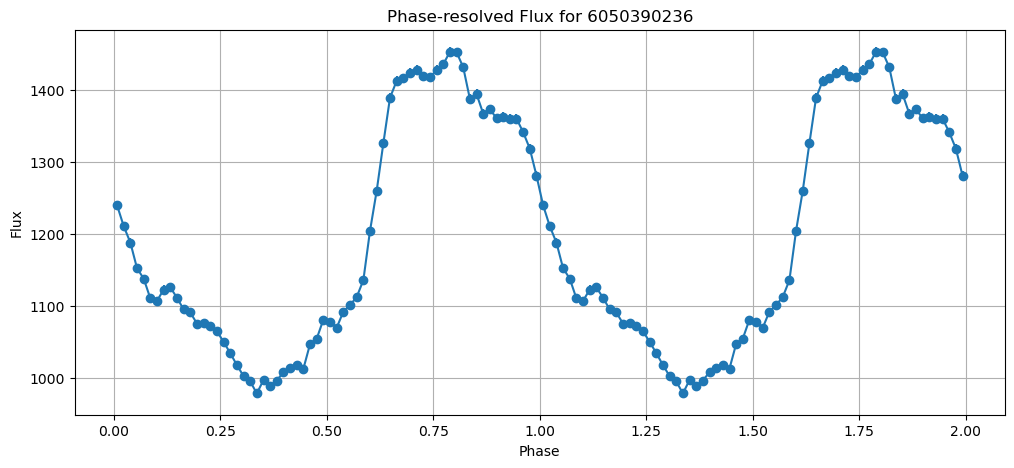

TSTART: 299293472.0
Processing file: 6050390237
First event time: 299293472.0
Last event time: 299372063.95
Total duration: 78591.94999998808 seconds
raw time value: [2.99293472e+08 2.99293472e+08 2.99293472e+08 2.99293472e+08
 2.99293472e+08 2.99293472e+08 2.99293472e+08 2.99293472e+08
 2.99293472e+08 2.99293472e+08]
converted from reference epoch time:  [3.0012379e+08 3.0012379e+08 3.0012379e+08 3.0012379e+08 3.0012379e+08
 3.0012379e+08 3.0012379e+08 3.0012379e+08 3.0012379e+08 3.0012379e+08]


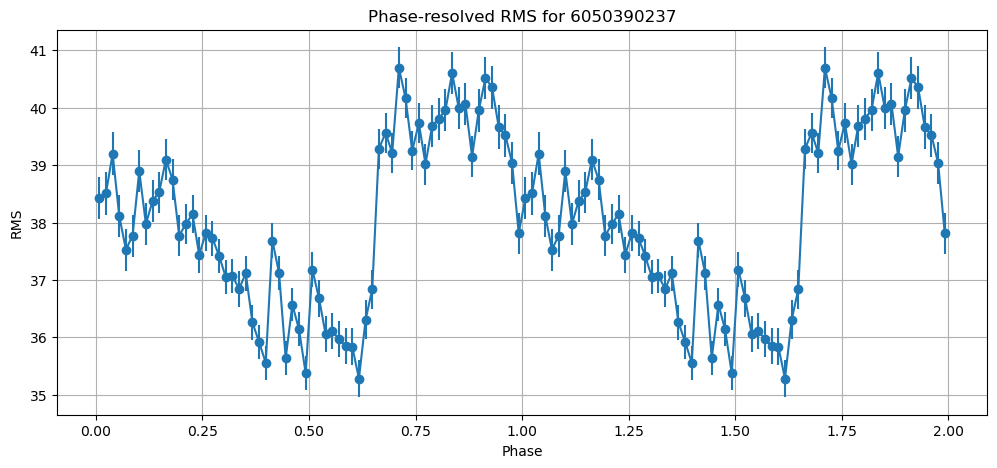

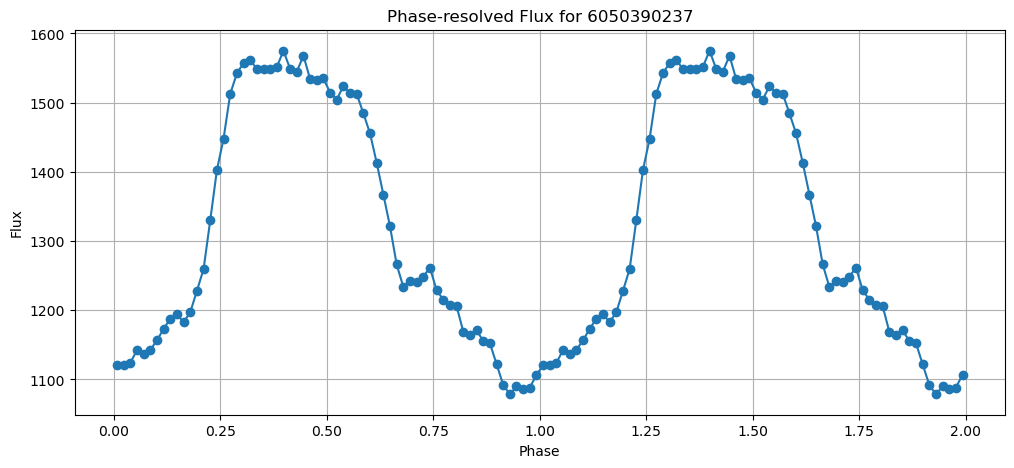

TSTART: 299377184.0
Processing file: 6050390238
First event time: 299377184.0
Last event time: 299438911.95
Total duration: 61727.94999998808 seconds
raw time value: [2.99377184e+08 2.99377184e+08 2.99377184e+08 2.99377184e+08
 2.99377184e+08 2.99377184e+08 2.99377184e+08 2.99377184e+08
 2.99377184e+08 2.99377184e+08]
converted from reference epoch time:  [3.00291214e+08 3.00291214e+08 3.00291214e+08 3.00291214e+08
 3.00291214e+08 3.00291214e+08 3.00291214e+08 3.00291214e+08
 3.00291214e+08 3.00291214e+08]


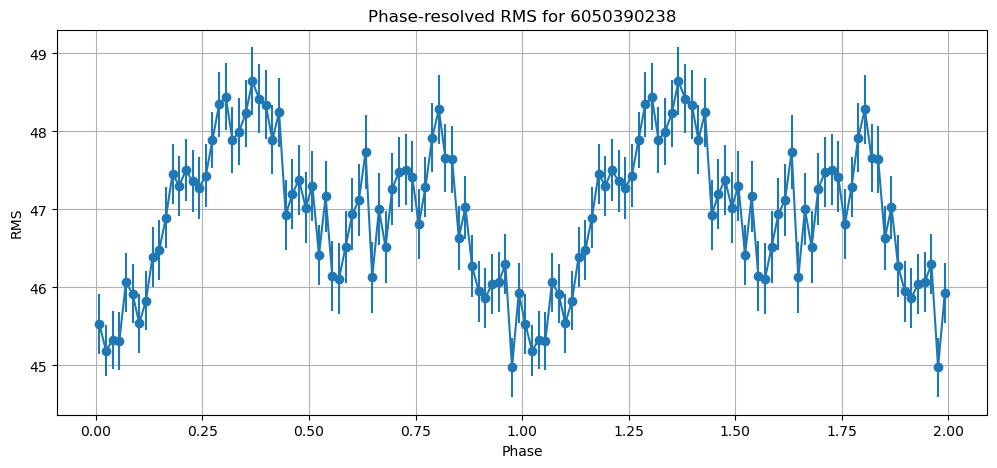

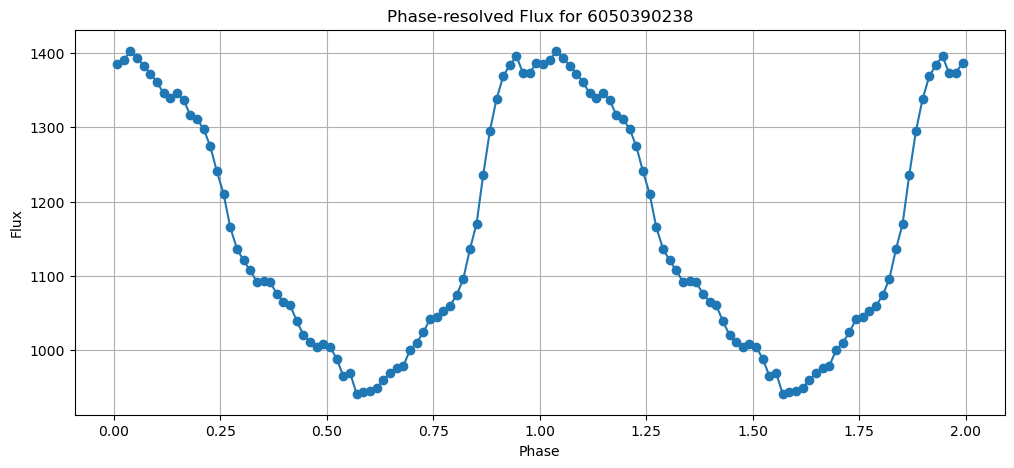

TSTART: 299471776.0
Processing file: 6050390239
First event time: 299471776.0
Last event time: 299511359.95
Total duration: 39583.94999998808 seconds
raw time value: [2.99471776e+08 2.99471776e+08 2.99471776e+08 2.99471776e+08
 2.99471776e+08 2.99471776e+08 2.99471776e+08 2.99471776e+08
 2.99471776e+08 2.99471776e+08]
converted from reference epoch time:  [3.00480398e+08 3.00480398e+08 3.00480398e+08 3.00480398e+08
 3.00480398e+08 3.00480398e+08 3.00480398e+08 3.00480398e+08
 3.00480398e+08 3.00480398e+08]


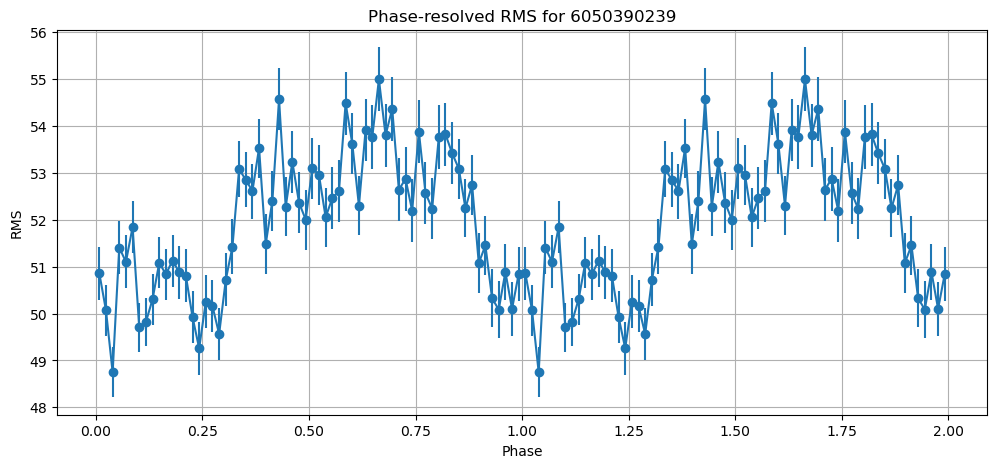

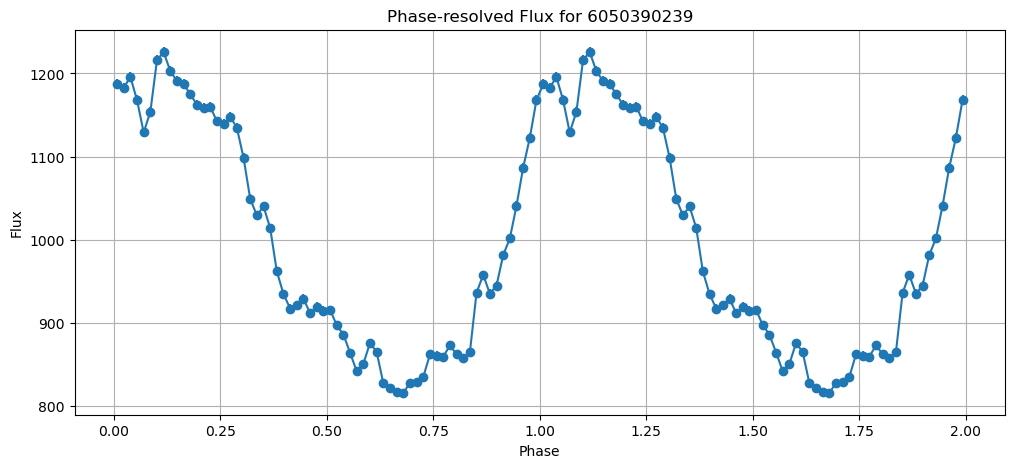

TSTART: 299599872.0
Processing file: 6050390240
First event time: 299599872.0
Last event time: 299611615.95
Total duration: 11743.949999988079 seconds
raw time value: [2.99599872e+08 2.99599872e+08 2.99599872e+08 2.99599872e+08
 2.99599872e+08 2.99599872e+08 2.99599872e+08 2.99599872e+08
 2.99599872e+08 2.99599872e+08]
converted from reference epoch time:  [3.0073659e+08 3.0073659e+08 3.0073659e+08 3.0073659e+08 3.0073659e+08
 3.0073659e+08 3.0073659e+08 3.0073659e+08 3.0073659e+08 3.0073659e+08]


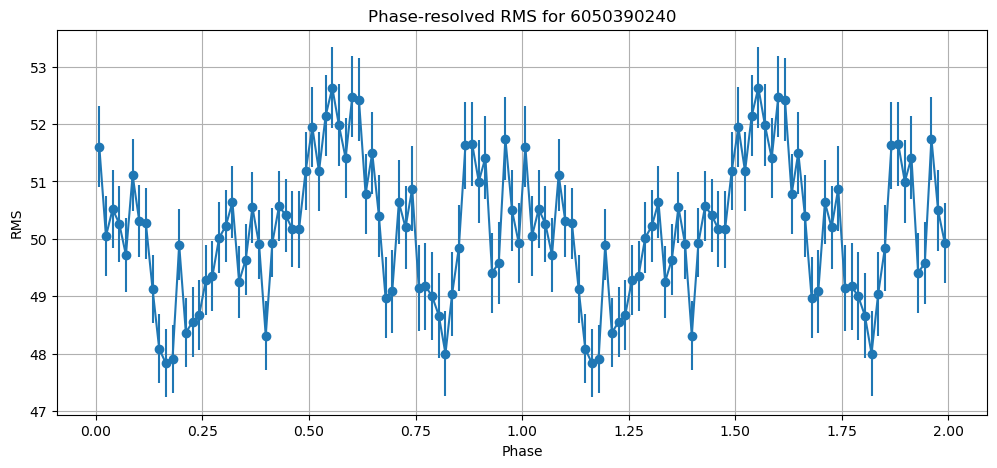

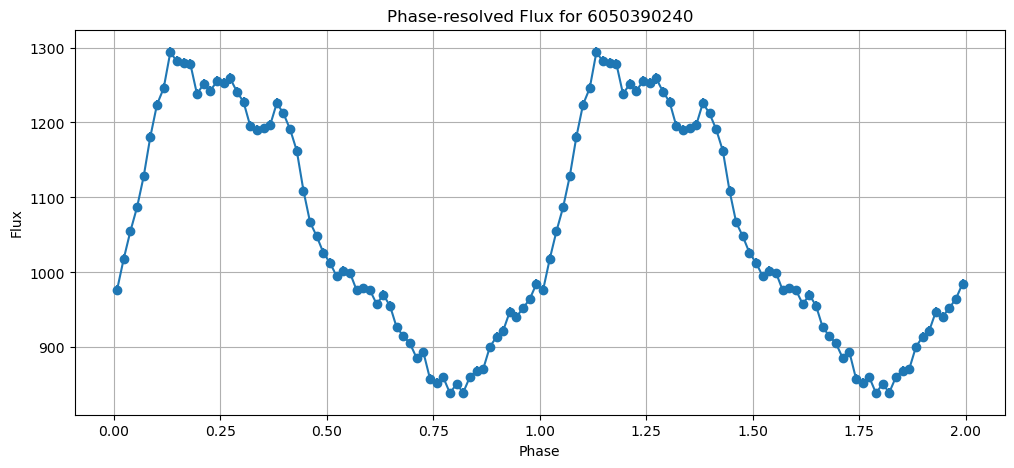

TSTART: 299700192.0
Processing file: 6050390241
First event time: 299700192.0
Last event time: 299711871.95
Total duration: 11679.949999988079 seconds
raw time value: [2.99700192e+08 2.99700192e+08 2.99700192e+08 2.99700192e+08
 2.99700192e+08 2.99700192e+08 2.99700192e+08 2.99700192e+08
 2.99700192e+08 2.99700192e+08]
converted from reference epoch time:  [3.0093723e+08 3.0093723e+08 3.0093723e+08 3.0093723e+08 3.0093723e+08
 3.0093723e+08 3.0093723e+08 3.0093723e+08 3.0093723e+08 3.0093723e+08]


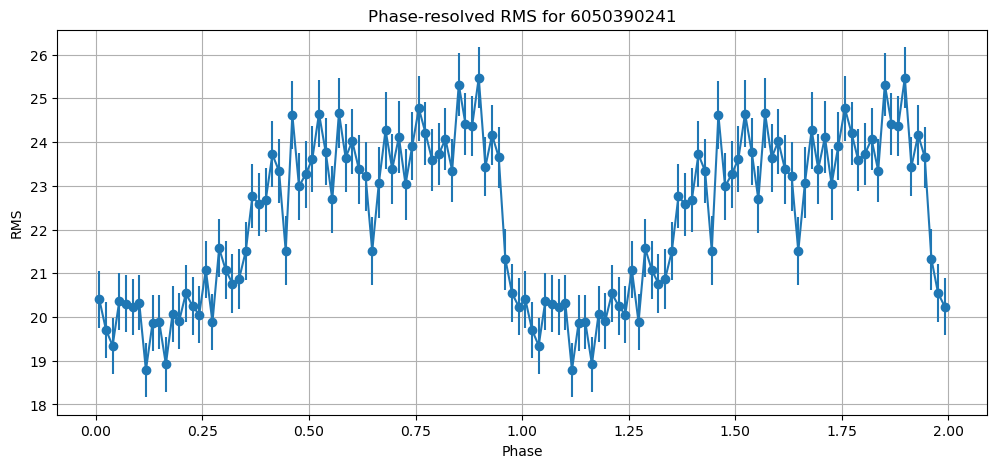

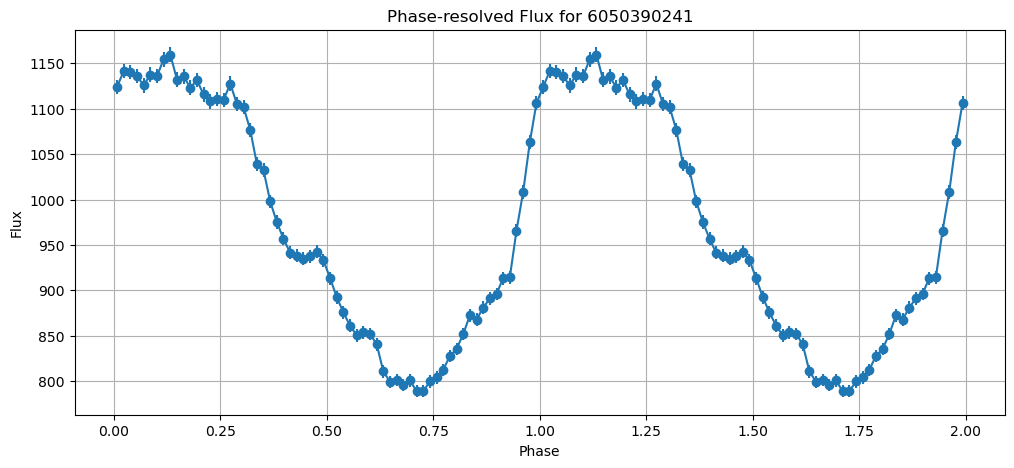

TSTART: 299789248.0
Processing file: 6050390242
First event time: 299789248.0
Last event time: 299800991.95
Total duration: 11743.949999988079 seconds
raw time value: [2.99789248e+08 2.99789248e+08 2.99789248e+08 2.99789248e+08
 2.99789248e+08 2.99789248e+08 2.99789248e+08 2.99789248e+08
 2.99789248e+08 2.99789248e+08]
converted from reference epoch time:  [3.01115342e+08 3.01115342e+08 3.01115342e+08 3.01115342e+08
 3.01115342e+08 3.01115342e+08 3.01115342e+08 3.01115342e+08
 3.01115342e+08 3.01115342e+08]


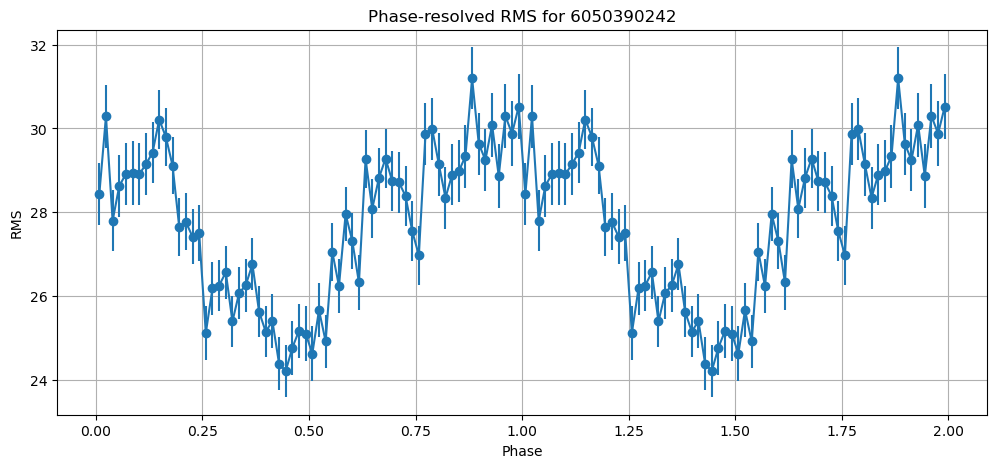

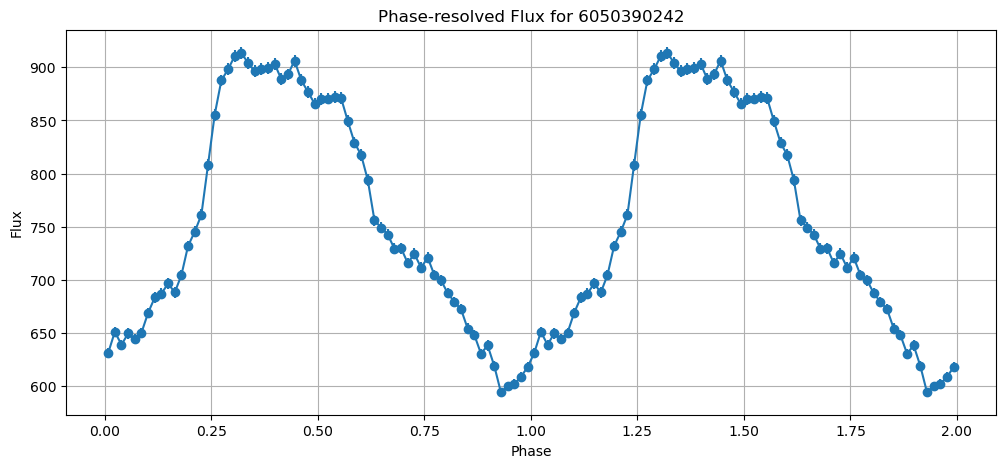

TSTART: 299861632.0
Processing file: 6050390243
First event time: 299861632.0
Last event time: 299890079.95
Total duration: 28447.94999998808 seconds
raw time value: [2.99861632e+08 2.99861632e+08 2.99861632e+08 2.99861632e+08
 2.99861632e+08 2.99861632e+08 2.99861632e+08 2.99861632e+08
 2.99861632e+08 2.99861632e+08]
converted from reference epoch time:  [3.0126011e+08 3.0126011e+08 3.0126011e+08 3.0126011e+08 3.0126011e+08
 3.0126011e+08 3.0126011e+08 3.0126011e+08 3.0126011e+08 3.0126011e+08]


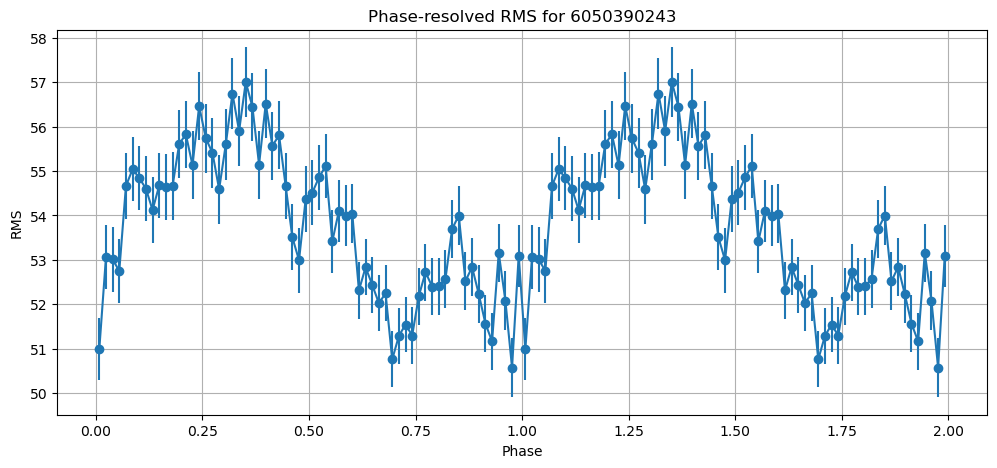

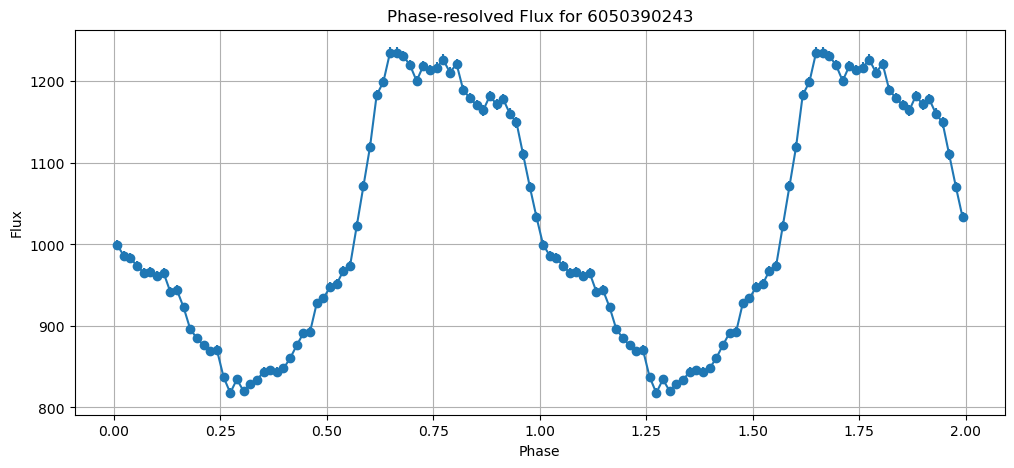

TSTART: 300001120.0
Processing file: 6050390244
First event time: 300001120.0
Last event time: 300046047.95
Total duration: 44927.94999998808 seconds
raw time value: [3.0000112e+08 3.0000112e+08 3.0000112e+08 3.0000112e+08 3.0000112e+08
 3.0000112e+08 3.0000112e+08 3.0000112e+08 3.0000112e+08 3.0000112e+08]
converted from reference epoch time:  [3.01539086e+08 3.01539086e+08 3.01539086e+08 3.01539086e+08
 3.01539086e+08 3.01539086e+08 3.01539086e+08 3.01539086e+08
 3.01539086e+08 3.01539086e+08]


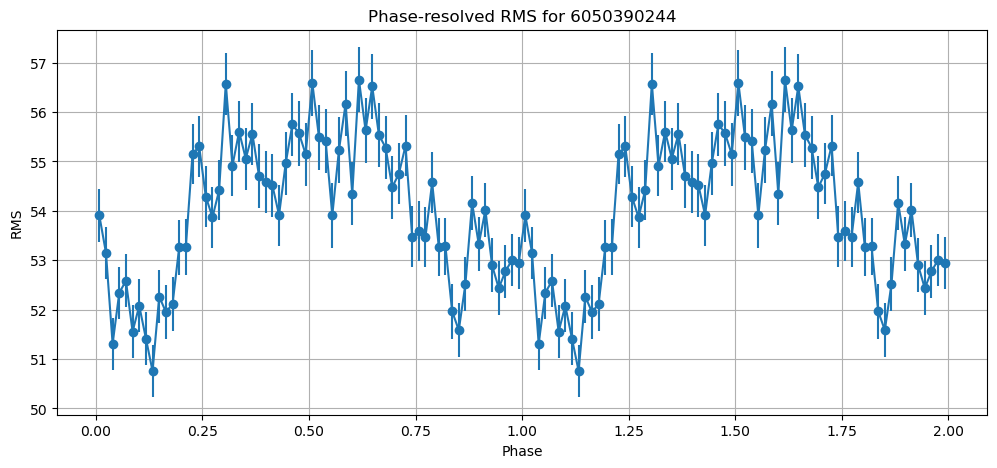

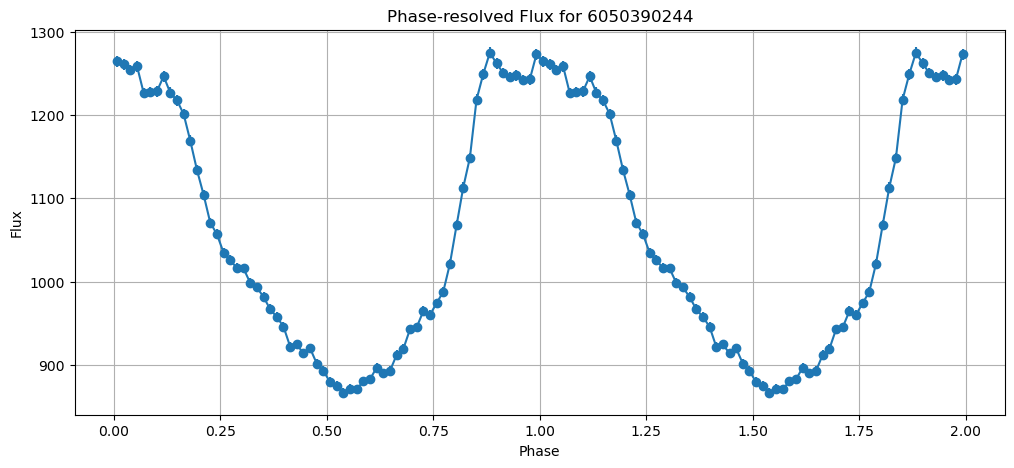

TSTART: 300871552.0
Processing file: 6050390247
First event time: 300871552.0
Last event time: 300905503.95
Total duration: 33951.94999998808 seconds
raw time value: [3.00871552e+08 3.00871552e+08 3.00871552e+08 3.00871552e+08
 3.00871552e+08 3.00871552e+08 3.00871552e+08 3.00871552e+08
 3.00871552e+08 3.00871552e+08]
converted from reference epoch time:  [3.0327995e+08 3.0327995e+08 3.0327995e+08 3.0327995e+08 3.0327995e+08
 3.0327995e+08 3.0327995e+08 3.0327995e+08 3.0327995e+08 3.0327995e+08]


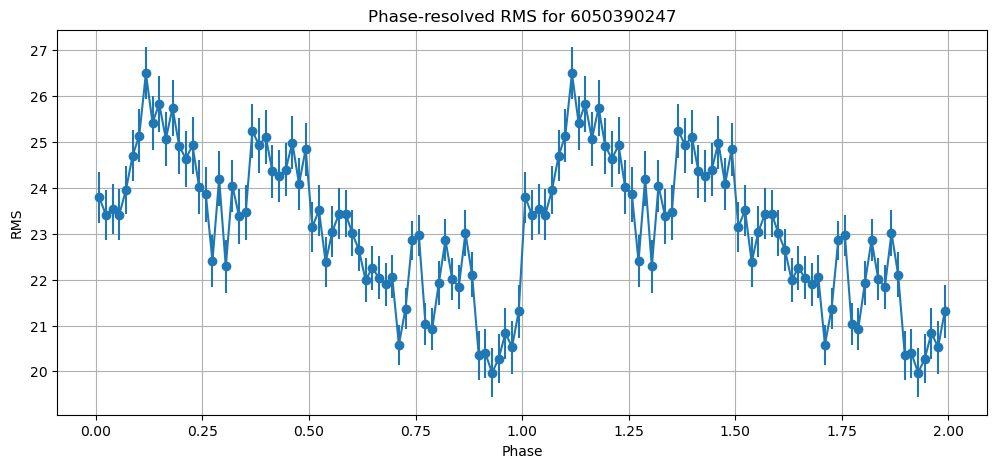

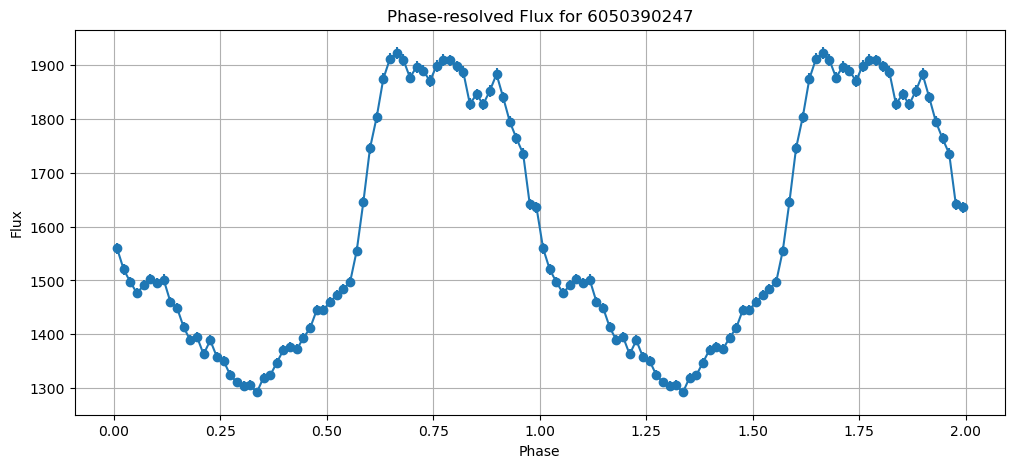

TSTART: 300954880.0
Processing file: 6050390248
First event time: 300954880.0
Last event time: 301006239.95
Total duration: 51359.94999998808 seconds
raw time value: [3.0095488e+08 3.0095488e+08 3.0095488e+08 3.0095488e+08 3.0095488e+08
 3.0095488e+08 3.0095488e+08 3.0095488e+08 3.0095488e+08 3.0095488e+08]
converted from reference epoch time:  [3.03446606e+08 3.03446606e+08 3.03446606e+08 3.03446606e+08
 3.03446606e+08 3.03446606e+08 3.03446606e+08 3.03446606e+08
 3.03446606e+08 3.03446606e+08]


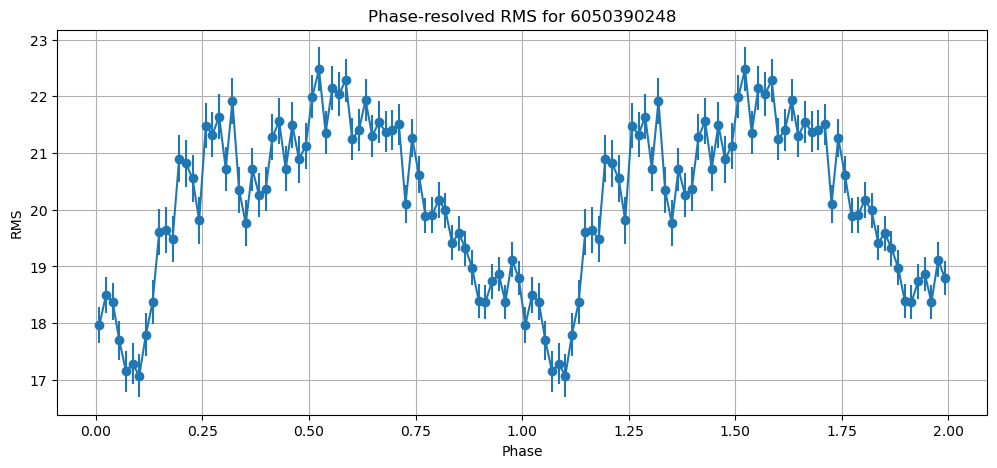

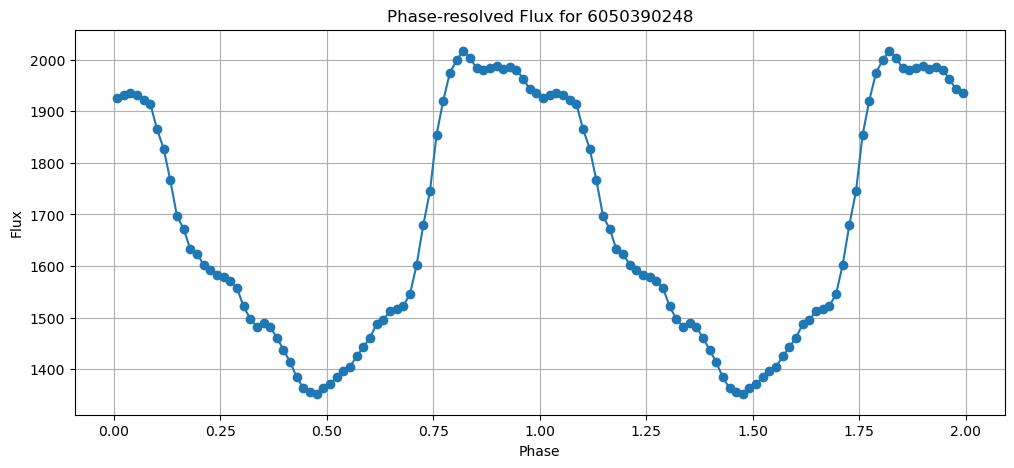

TSTART: 301211584.0
Processing file: 6050390251
First event time: 301211584.0
Last event time: 301251551.95
Total duration: 39967.94999998808 seconds
raw time value: [3.01211584e+08 3.01211584e+08 3.01211584e+08 3.01211584e+08
 3.01211584e+08 3.01211584e+08 3.01211584e+08 3.01211584e+08
 3.01211584e+08 3.01211584e+08]
converted from reference epoch time:  [3.03960014e+08 3.03960014e+08 3.03960014e+08 3.03960014e+08
 3.03960014e+08 3.03960014e+08 3.03960014e+08 3.03960014e+08
 3.03960014e+08 3.03960014e+08]


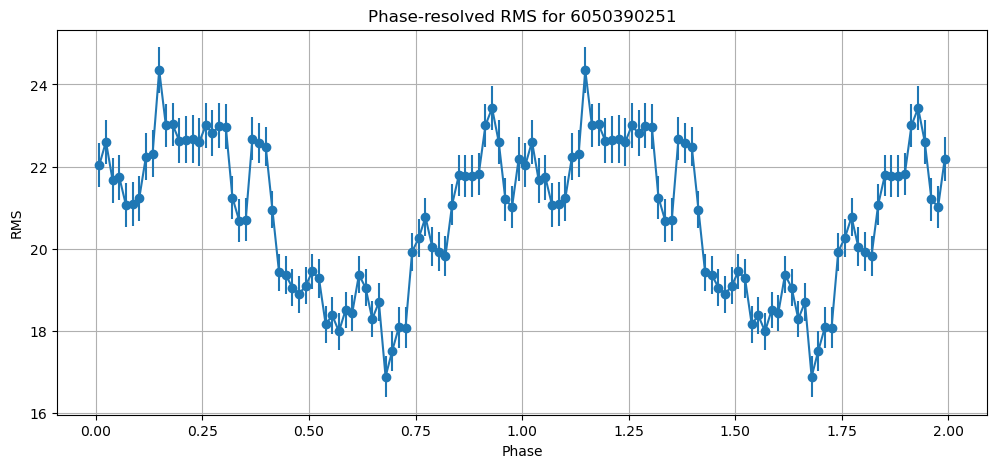

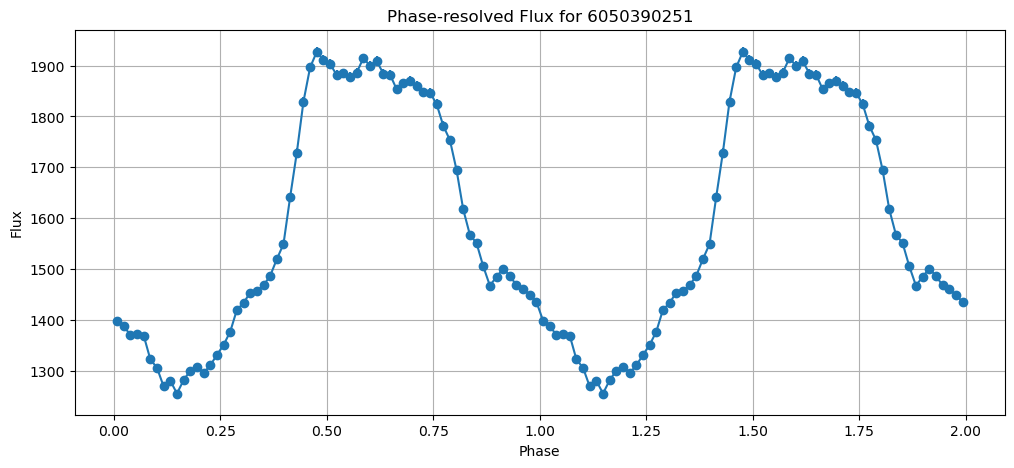

TSTART: 301300896.0
Processing file: 6050390252
First event time: 301300896.0
Last event time: 301357375.95
Total duration: 56479.94999998808 seconds
raw time value: [3.01300896e+08 3.01300896e+08 3.01300896e+08 3.01300896e+08
 3.01300896e+08 3.01300896e+08 3.01300896e+08 3.01300896e+08
 3.01300896e+08 3.01300896e+08]
converted from reference epoch time:  [3.04138638e+08 3.04138638e+08 3.04138638e+08 3.04138638e+08
 3.04138638e+08 3.04138638e+08 3.04138638e+08 3.04138638e+08
 3.04138638e+08 3.04138638e+08]


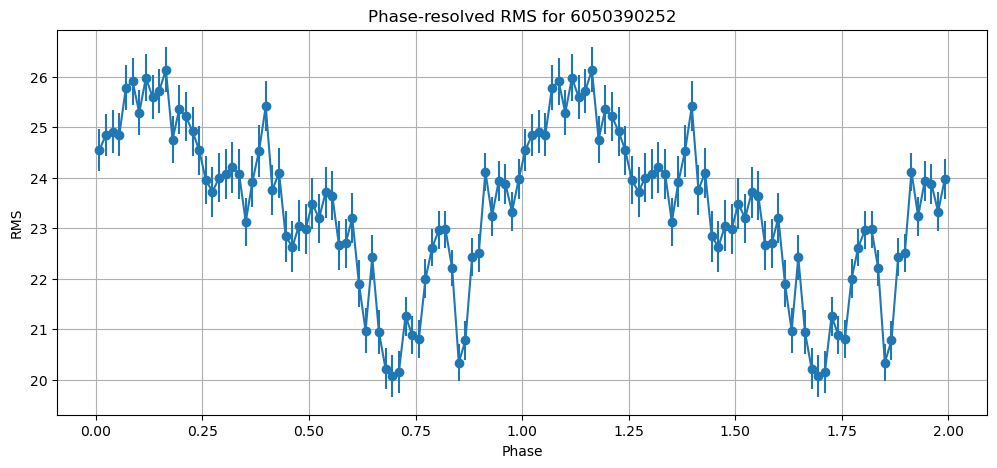

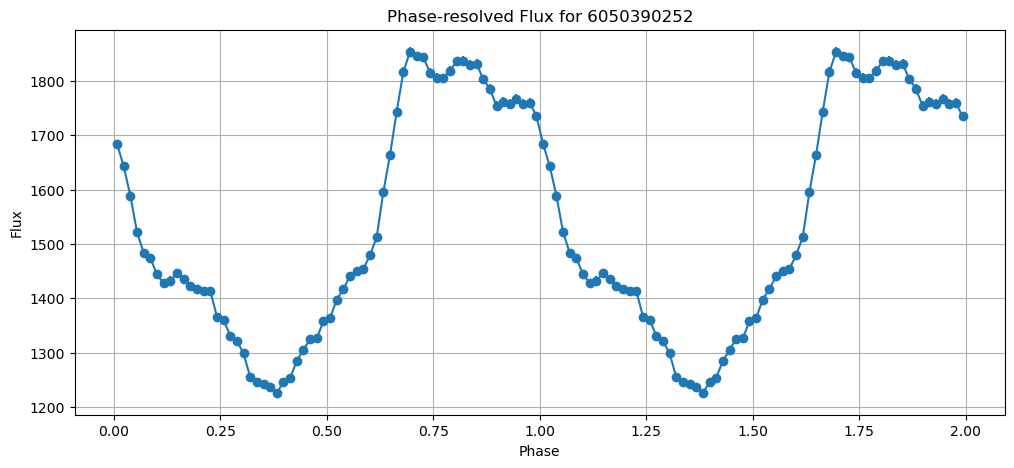

TSTART: 301451712.0
Processing file: 6050390254
First event time: 301451712.0
Last event time: 301518687.95
Total duration: 66975.94999998808 seconds
raw time value: [3.01451712e+08 3.01451712e+08 3.01451712e+08 3.01451712e+08
 3.01451712e+08 3.01451712e+08 3.01451712e+08 3.01451712e+08
 3.01451712e+08 3.01451712e+08]
converted from reference epoch time:  [3.0444027e+08 3.0444027e+08 3.0444027e+08 3.0444027e+08 3.0444027e+08
 3.0444027e+08 3.0444027e+08 3.0444027e+08 3.0444027e+08 3.0444027e+08]


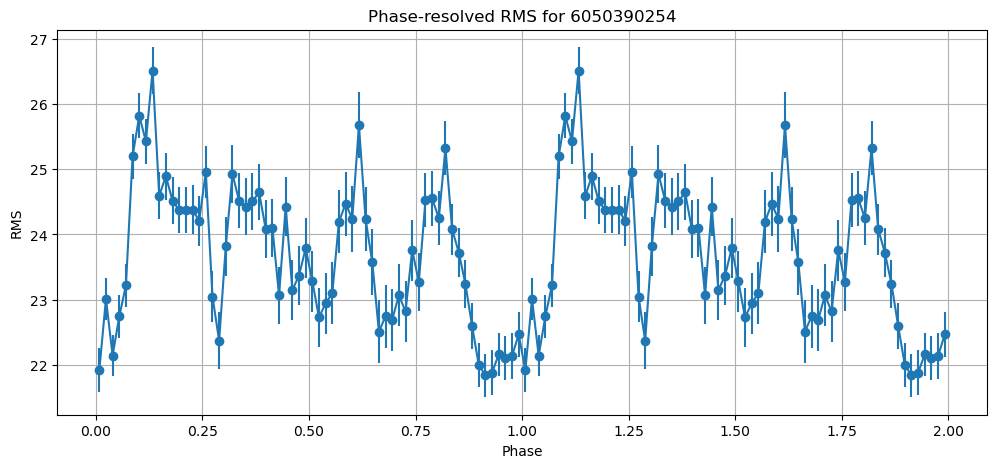

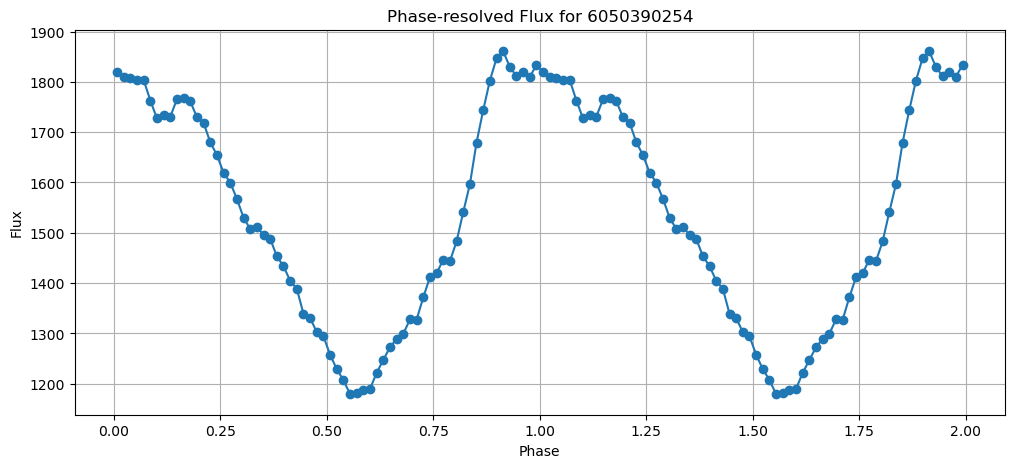

TSTART: 303303520.0
Processing file: 6050390255
First event time: 303303520.0
Last event time: 303348383.95
Total duration: 44863.94999998808 seconds
raw time value: [3.0330352e+08 3.0330352e+08 3.0330352e+08 3.0330352e+08 3.0330352e+08
 3.0330352e+08 3.0330352e+08 3.0330352e+08 3.0330352e+08 3.0330352e+08]
converted from reference epoch time:  [3.08143886e+08 3.08143886e+08 3.08143886e+08 3.08143886e+08
 3.08143886e+08 3.08143886e+08 3.08143886e+08 3.08143886e+08
 3.08143886e+08 3.08143886e+08]


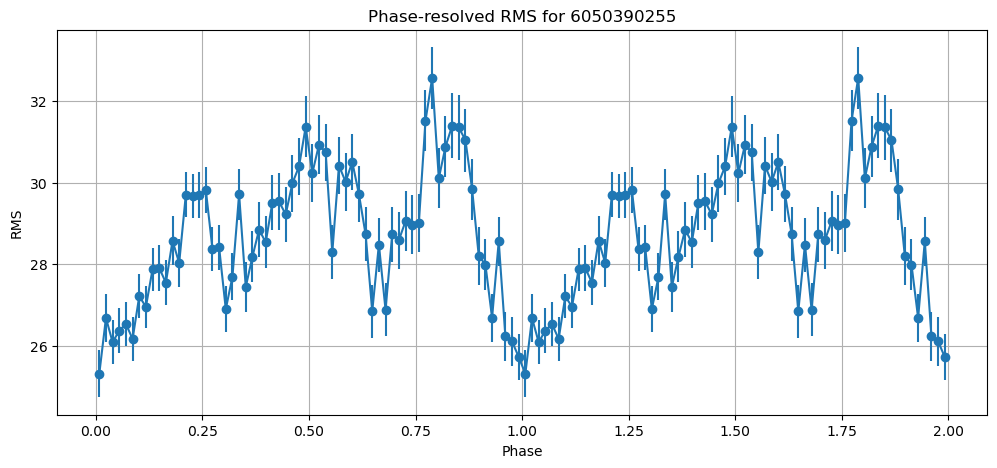

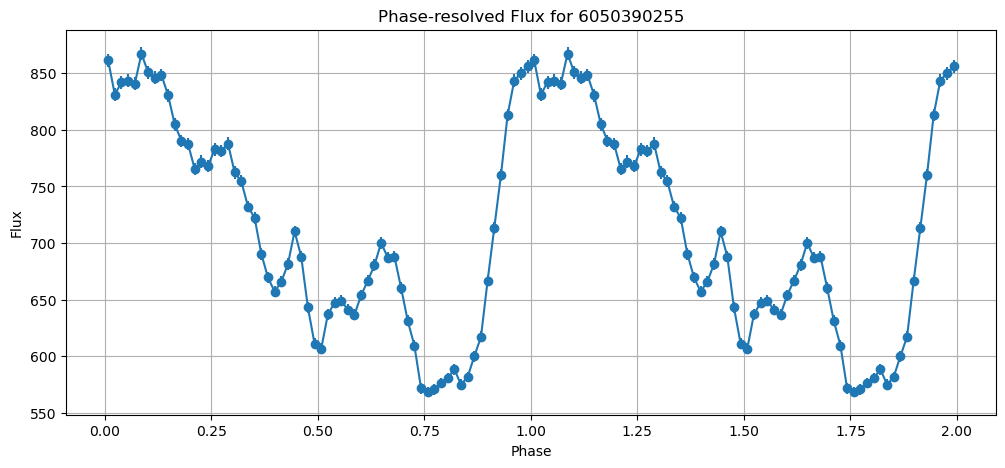

TSTART: 303353696.0
Processing file: 6050390256
First event time: 303353696.0
Last event time: 303432127.95
Total duration: 78431.94999998808 seconds
raw time value: [3.03353696e+08 3.03353696e+08 3.03353696e+08 3.03353696e+08
 3.03353696e+08 3.03353696e+08 3.03353696e+08 3.03353696e+08
 3.03353696e+08 3.03353696e+08]
converted from reference epoch time:  [3.08244238e+08 3.08244238e+08 3.08244238e+08 3.08244238e+08
 3.08244238e+08 3.08244238e+08 3.08244238e+08 3.08244238e+08
 3.08244238e+08 3.08244238e+08]


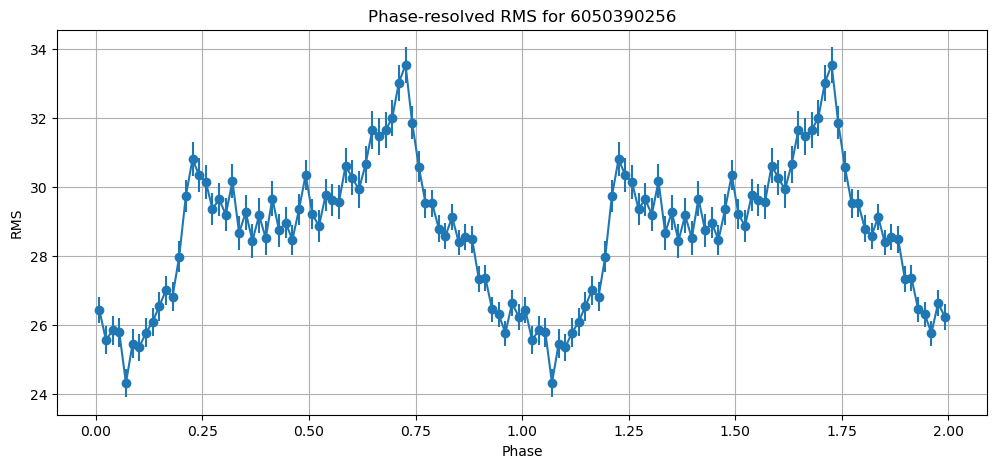

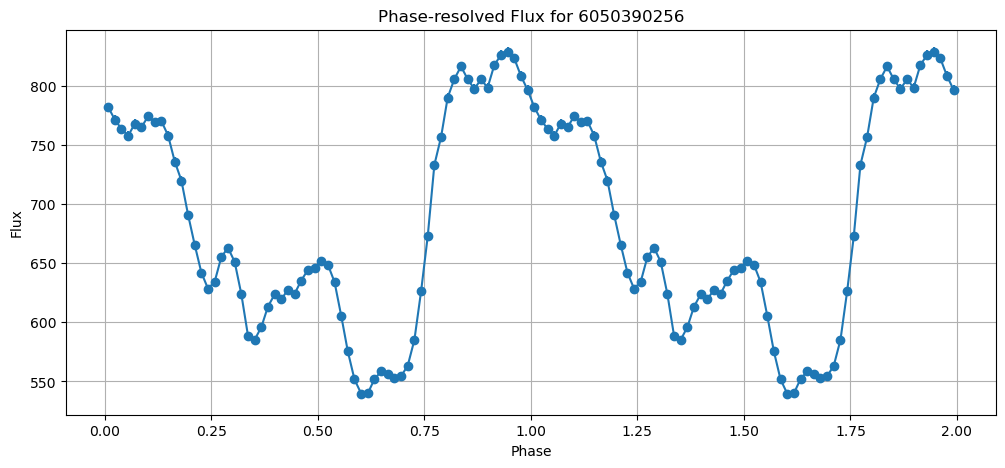

TSTART: 303537856.0
Processing file: 6050390258
First event time: 303537856.0
Last event time: 303605183.95
Total duration: 67327.94999998808 seconds
raw time value: [3.03537856e+08 3.03537856e+08 3.03537856e+08 3.03537856e+08
 3.03537856e+08 3.03537856e+08 3.03537856e+08 3.03537856e+08
 3.03537856e+08 3.03537856e+08]
converted from reference epoch time:  [3.08612558e+08 3.08612558e+08 3.08612558e+08 3.08612558e+08
 3.08612558e+08 3.08612558e+08 3.08612558e+08 3.08612558e+08
 3.08612558e+08 3.08612558e+08]


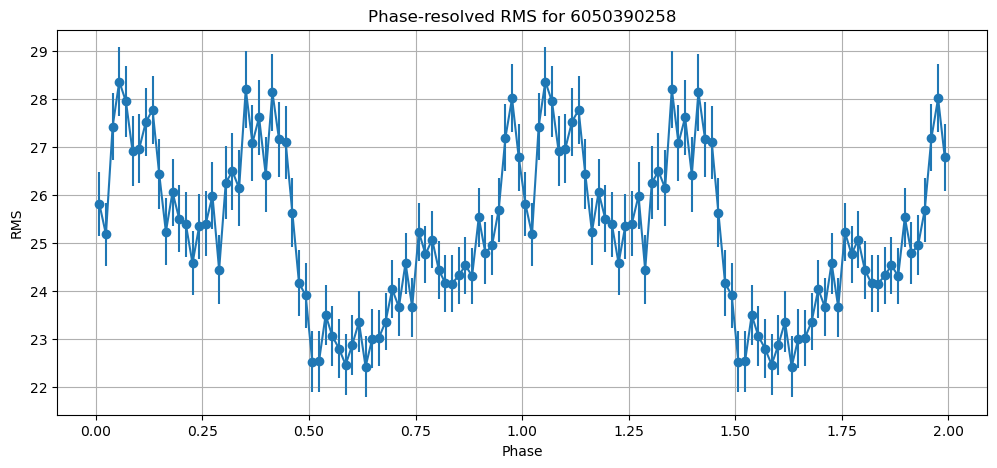

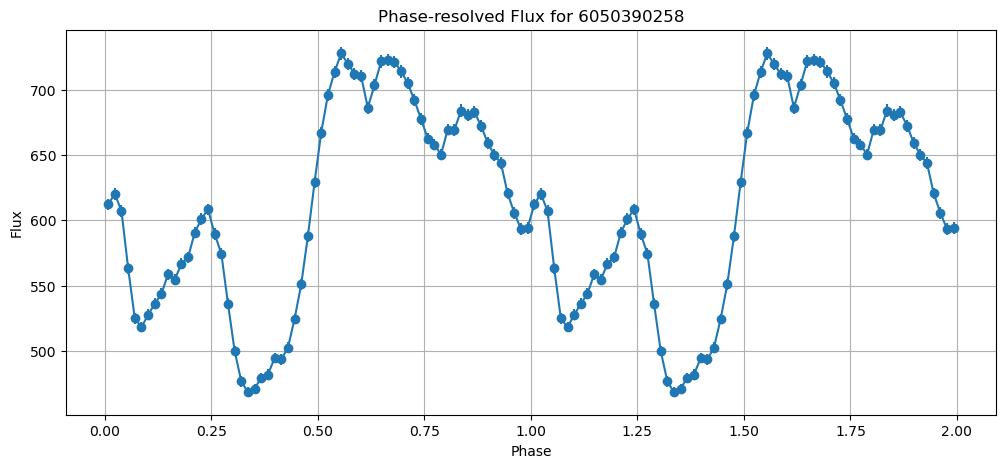

TSTART: 303788704.0
Processing file: 6050390261
First event time: 303788704.0
Last event time: 303856351.95
Total duration: 67647.94999998808 seconds
raw time value: [3.03788704e+08 3.03788704e+08 3.03788704e+08 3.03788704e+08
 3.03788704e+08 3.03788704e+08 3.03788704e+08 3.03788704e+08
 3.03788704e+08 3.03788704e+08]
converted from reference epoch time:  [3.09114254e+08 3.09114254e+08 3.09114254e+08 3.09114254e+08
 3.09114254e+08 3.09114254e+08 3.09114254e+08 3.09114254e+08
 3.09114254e+08 3.09114254e+08]


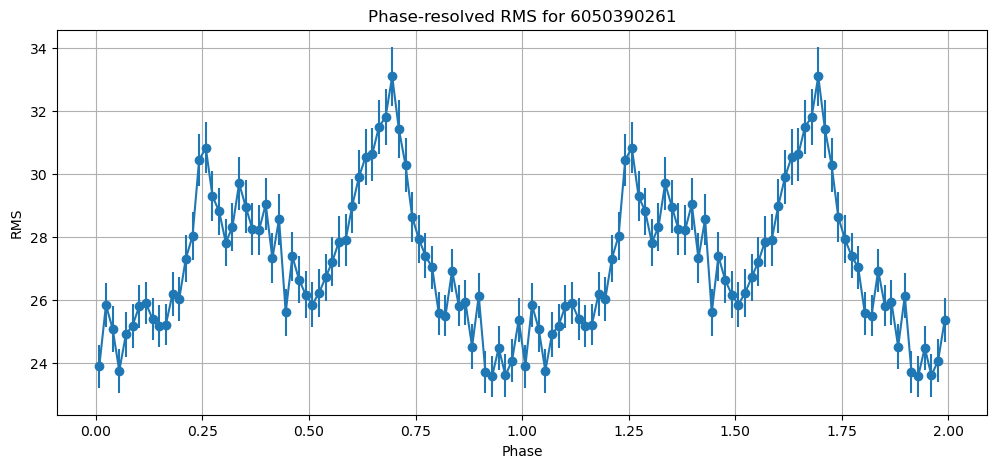

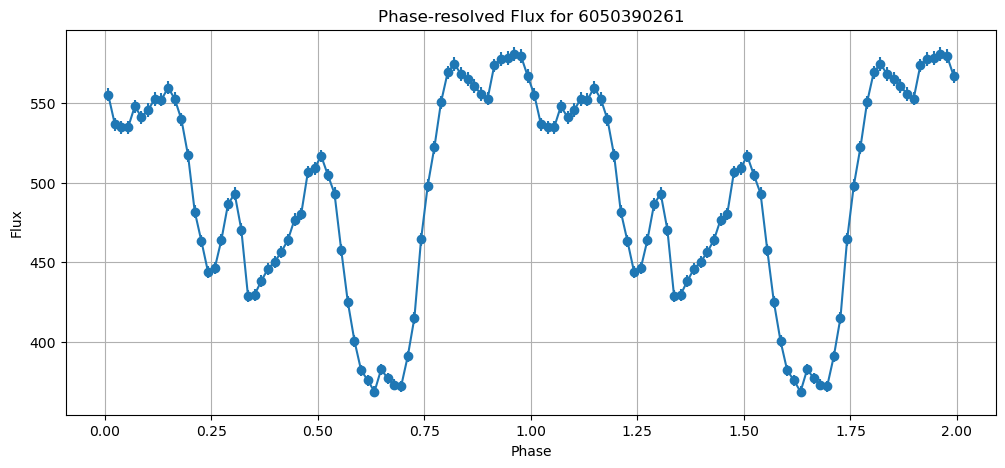

TSTART: 303889440.0
Processing file: 6050390262
First event time: 303889440.0
Last event time: 303923327.95
Total duration: 33887.94999998808 seconds
raw time value: [3.0388944e+08 3.0388944e+08 3.0388944e+08 3.0388944e+08 3.0388944e+08
 3.0388944e+08 3.0388944e+08 3.0388944e+08 3.0388944e+08 3.0388944e+08]
converted from reference epoch time:  [3.09315726e+08 3.09315726e+08 3.09315726e+08 3.09315726e+08
 3.09315726e+08 3.09315726e+08 3.09315726e+08 3.09315726e+08
 3.09315726e+08 3.09315726e+08]


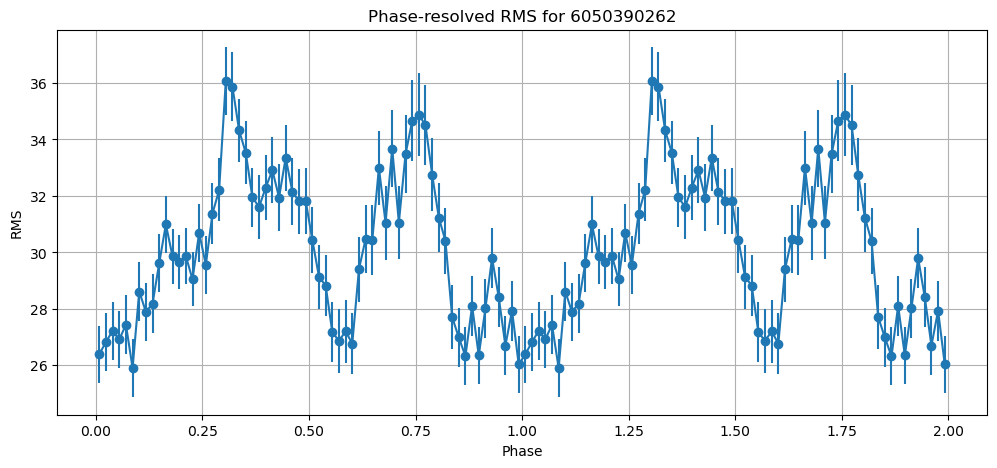

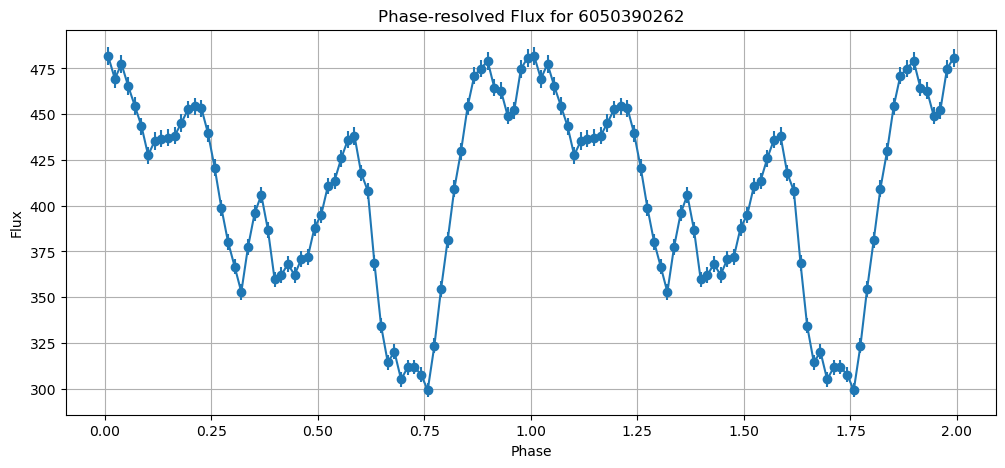

TSTART: 303989536.0
Processing file: 6050390263
First event time: 303989536.0
Last event time: 303990271.95
Total duration: 735.9499999880791 seconds
raw time value: [3.03989536e+08 3.03989536e+08 3.03989536e+08 3.03989536e+08
 3.03989536e+08 3.03989536e+08 3.03989536e+08 3.03989536e+08
 3.03989536e+08 3.03989536e+08]
converted from reference epoch time:  [3.09515918e+08 3.09515918e+08 3.09515918e+08 3.09515918e+08
 3.09515918e+08 3.09515918e+08 3.09515918e+08 3.09515918e+08
 3.09515918e+08 3.09515918e+08]


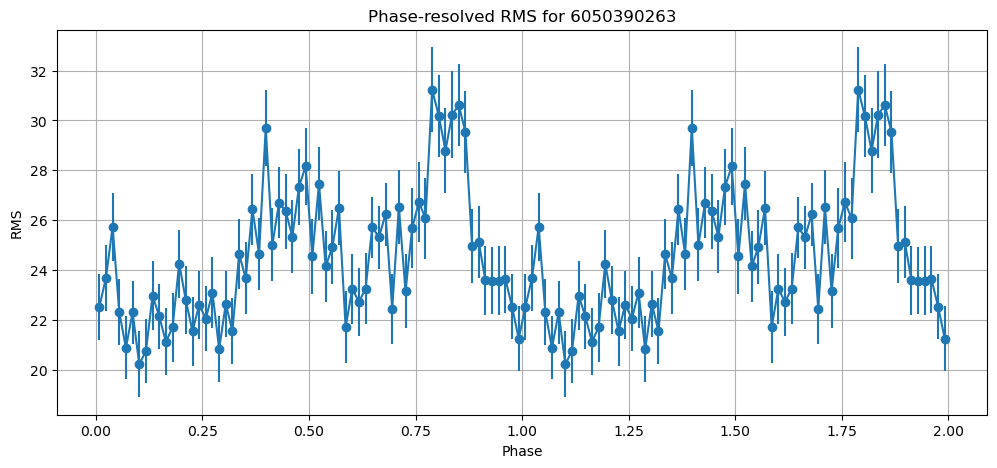

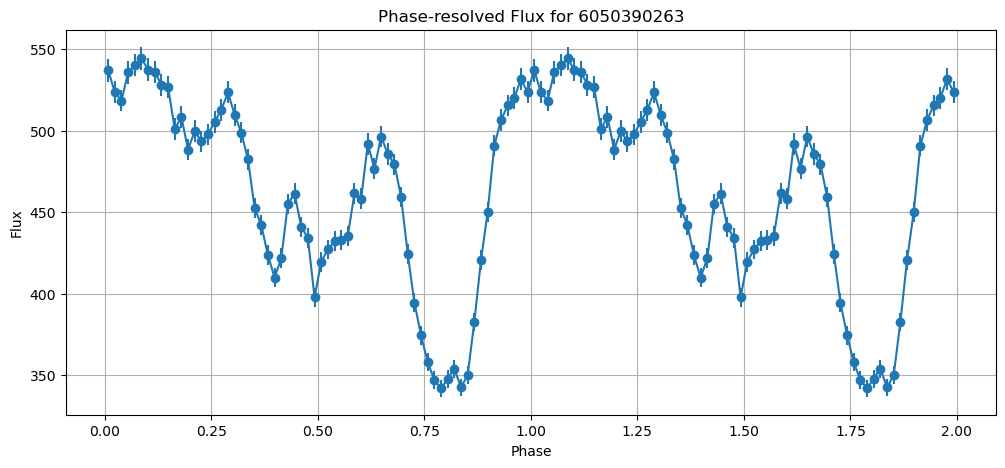

TSTART: 304056896.0
Processing file: 6050390264
First event time: 304056896.0
Last event time: 304124159.95
Total duration: 67263.94999998808 seconds
raw time value: [3.04056896e+08 3.04056896e+08 3.04056896e+08 3.04056896e+08
 3.04056896e+08 3.04056896e+08 3.04056896e+08 3.04056896e+08
 3.04056896e+08 3.04056896e+08]
converted from reference epoch time:  [3.09650638e+08 3.09650638e+08 3.09650638e+08 3.09650638e+08
 3.09650638e+08 3.09650638e+08 3.09650638e+08 3.09650638e+08
 3.09650638e+08 3.09650638e+08]


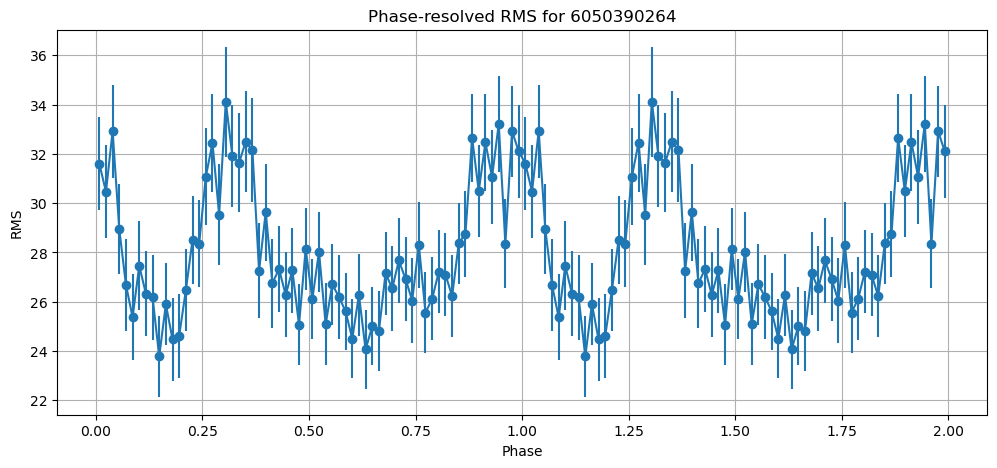

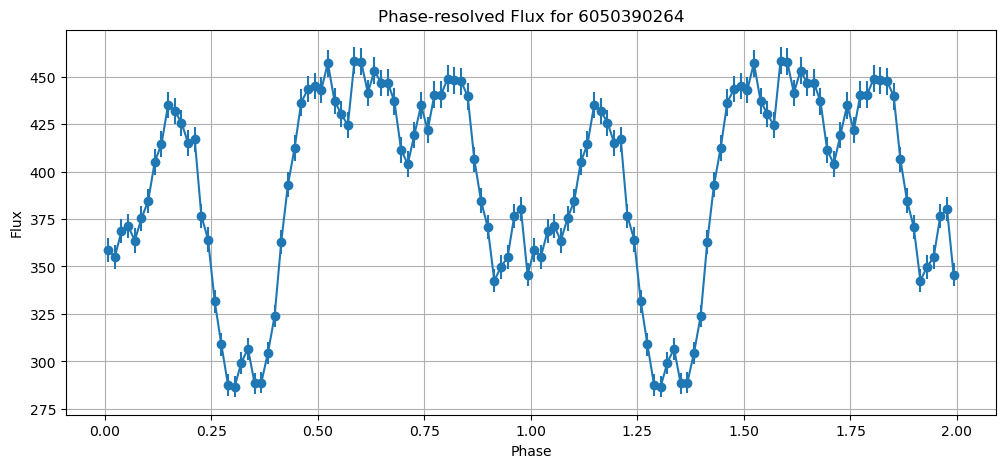

TSTART: 304273696.0
Processing file: 6050390265
First event time: 304273696.0
Last event time: 304274399.95
Total duration: 703.9499999880791 seconds
raw time value: [3.04273696e+08 3.04273696e+08 3.04273696e+08 3.04273696e+08
 3.04273696e+08 3.04273696e+08 3.04273696e+08 3.04273696e+08
 3.04273696e+08 3.04273696e+08]
converted from reference epoch time:  [3.10084238e+08 3.10084238e+08 3.10084238e+08 3.10084238e+08
 3.10084238e+08 3.10084238e+08 3.10084238e+08 3.10084238e+08
 3.10084238e+08 3.10084238e+08]


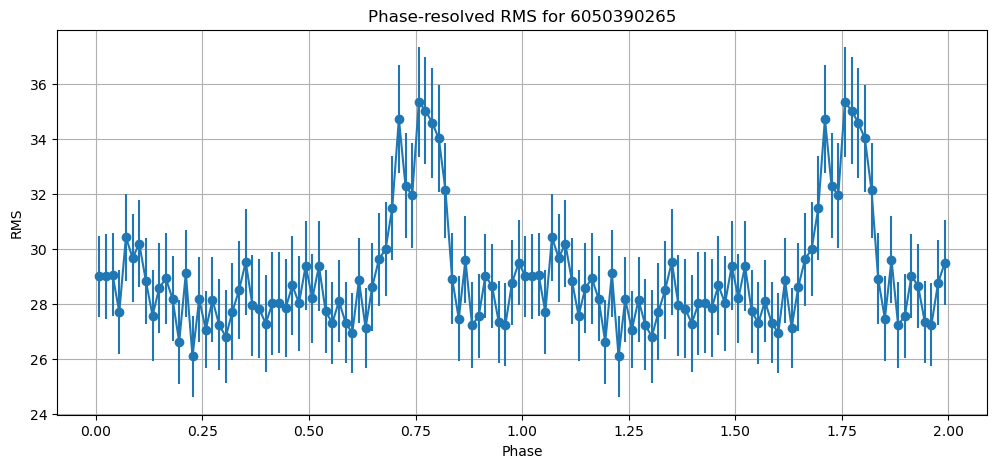

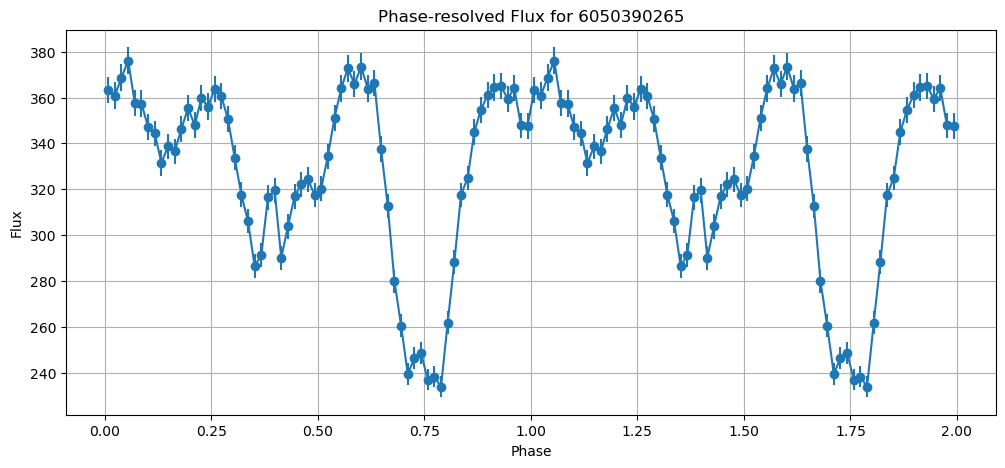

TSTART: 304452320.0
Processing file: 6050390266
First event time: 304452320.0
Last event time: 304453183.95
Total duration: 863.9499999880791 seconds
raw time value: [3.0445232e+08 3.0445232e+08 3.0445232e+08 3.0445232e+08 3.0445232e+08
 3.0445232e+08 3.0445232e+08 3.0445232e+08 3.0445232e+08 3.0445232e+08]
converted from reference epoch time:  [3.10441486e+08 3.10441486e+08 3.10441486e+08 3.10441486e+08
 3.10441486e+08 3.10441486e+08 3.10441486e+08 3.10441486e+08
 3.10441486e+08 3.10441486e+08]


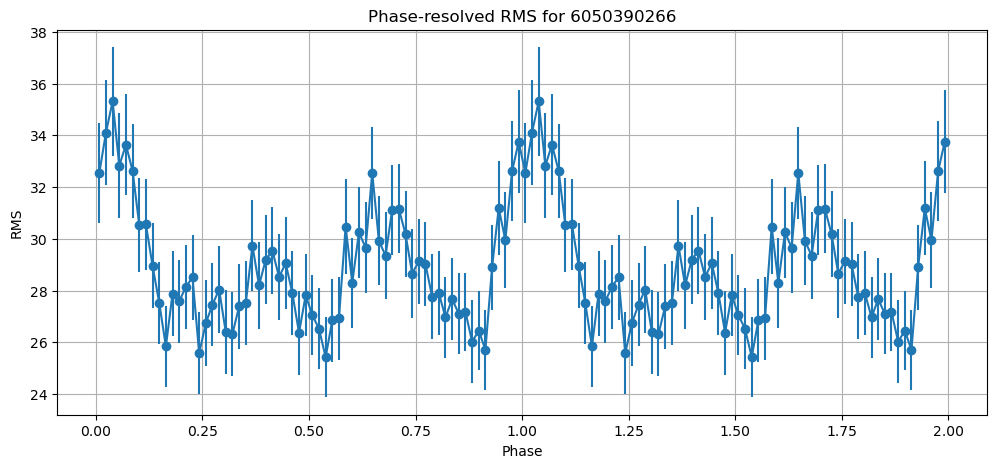

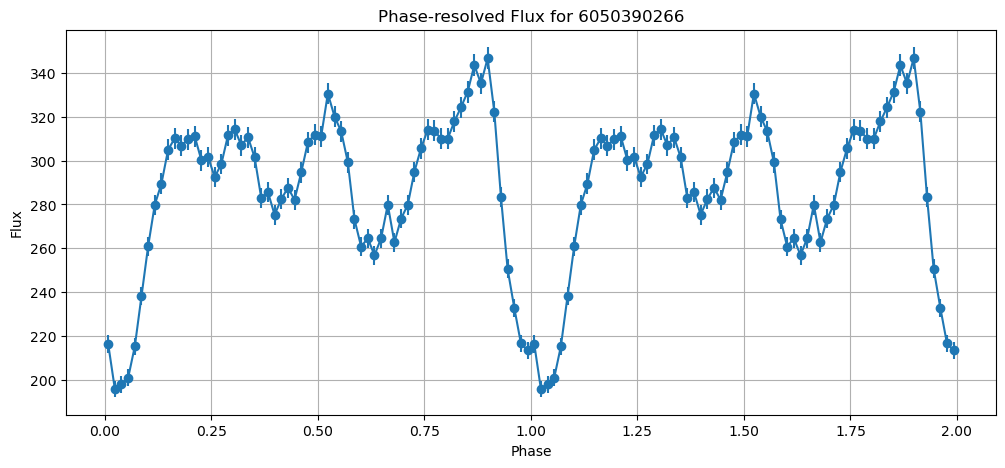

TSTART: 304486432.0
Processing file: 6050390267
First event time: 304486432.0
Last event time: 304514495.95
Total duration: 28063.94999998808 seconds
raw time value: [3.04486432e+08 3.04486432e+08 3.04486432e+08 3.04486432e+08
 3.04486432e+08 3.04486432e+08 3.04486432e+08 3.04486432e+08
 3.04486432e+08 3.04486432e+08]
converted from reference epoch time:  [3.1050971e+08 3.1050971e+08 3.1050971e+08 3.1050971e+08 3.1050971e+08
 3.1050971e+08 3.1050971e+08 3.1050971e+08 3.1050971e+08 3.1050971e+08]


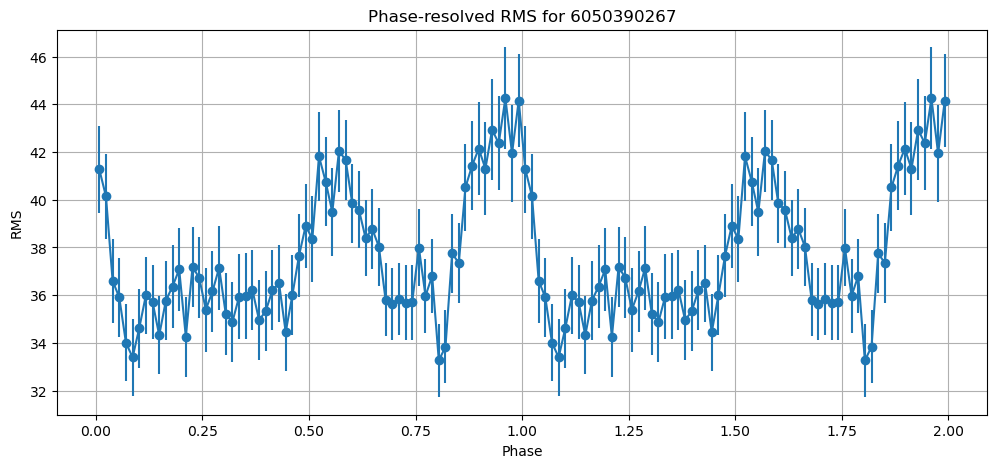

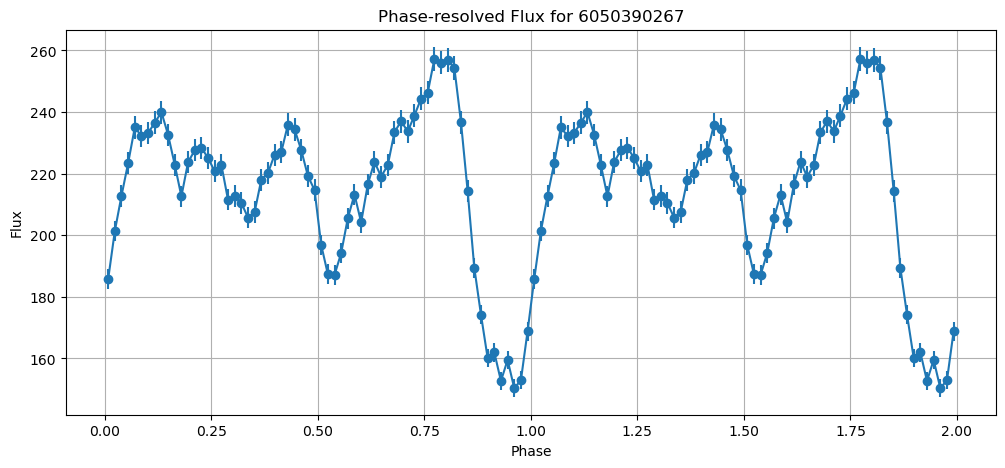

TSTART: 304742784.0
Processing file: 6050390270
First event time: 304742784.0
Last event time: 304787583.95
Total duration: 44799.94999998808 seconds
raw time value: [3.04742784e+08 3.04742784e+08 3.04742784e+08 3.04742784e+08
 3.04742784e+08 3.04742784e+08 3.04742784e+08 3.04742784e+08
 3.04742784e+08 3.04742784e+08]
converted from reference epoch time:  [3.11022414e+08 3.11022414e+08 3.11022414e+08 3.11022414e+08
 3.11022414e+08 3.11022414e+08 3.11022414e+08 3.11022414e+08
 3.11022414e+08 3.11022414e+08]


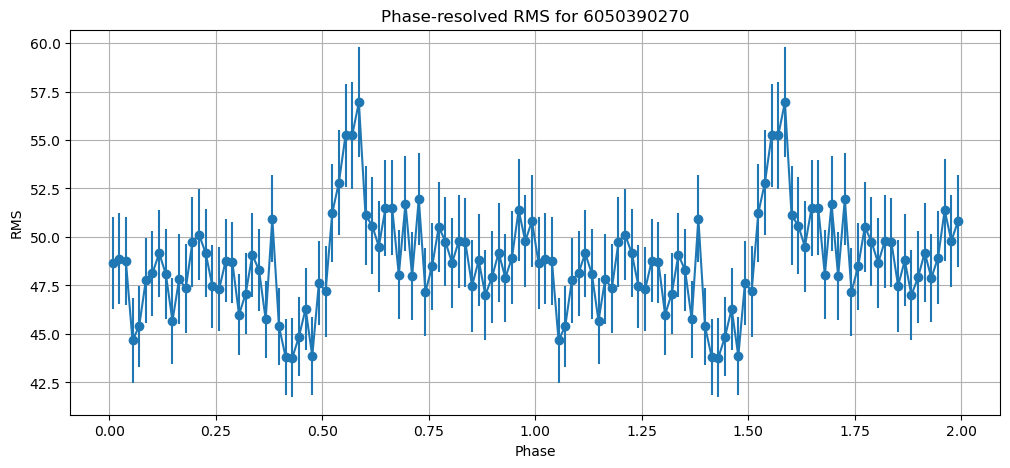

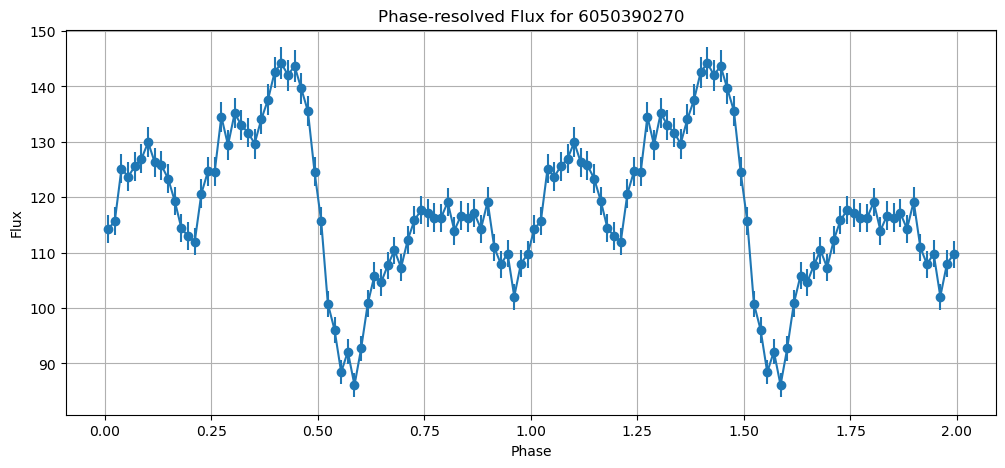

TSTART: 304971008.0
Processing file: 6050390272
First event time: 304971008.0
Last event time: 304977023.95
Total duration: 6015.949999988079 seconds
raw time value: [3.04971008e+08 3.04971008e+08 3.04971008e+08 3.04971008e+08
 3.04971008e+08 3.04971008e+08 3.04971008e+08 3.04971008e+08
 3.04971008e+08 3.04971008e+08]
converted from reference epoch time:  [3.11478862e+08 3.11478862e+08 3.11478862e+08 3.11478862e+08
 3.11478862e+08 3.11478862e+08 3.11478862e+08 3.11478862e+08
 3.11478862e+08 3.11478862e+08]


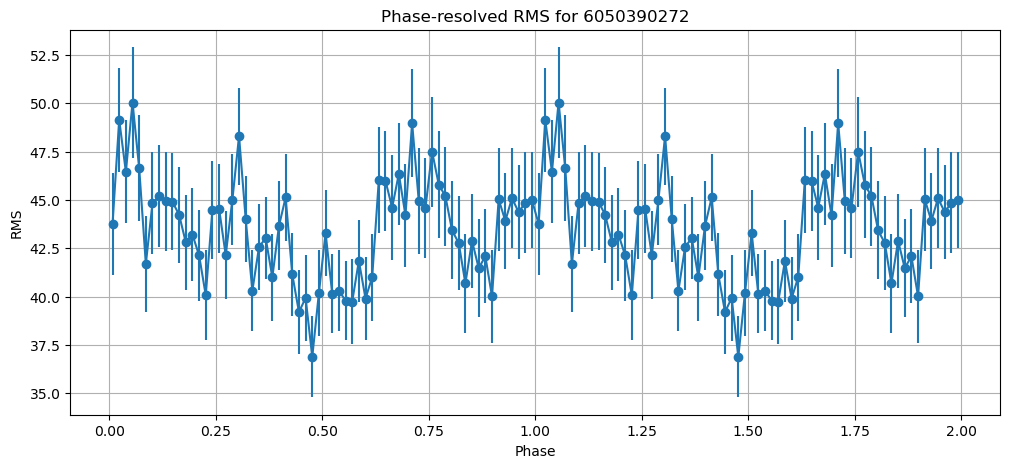

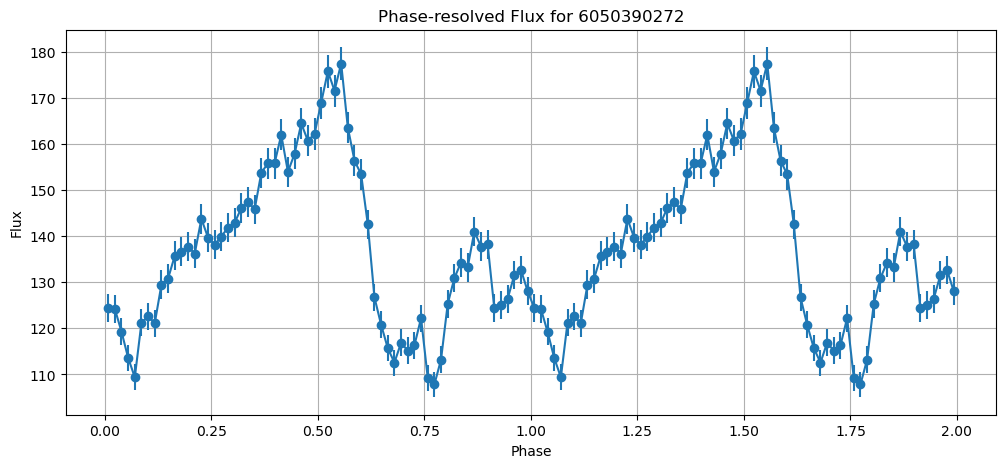

TSTART: 305377728.0
Processing file: 6050390276
First event time: 305377728.0
Last event time: 305406175.95
Total duration: 28447.94999998808 seconds
raw time value: [3.05377728e+08 3.05377728e+08 3.05377728e+08 3.05377728e+08
 3.05377728e+08 3.05377728e+08 3.05377728e+08 3.05377728e+08
 3.05377728e+08 3.05377728e+08]
converted from reference epoch time:  [3.12292302e+08 3.12292302e+08 3.12292302e+08 3.12292302e+08
 3.12292302e+08 3.12292302e+08 3.12292302e+08 3.12292302e+08
 3.12292302e+08 3.12292302e+08]


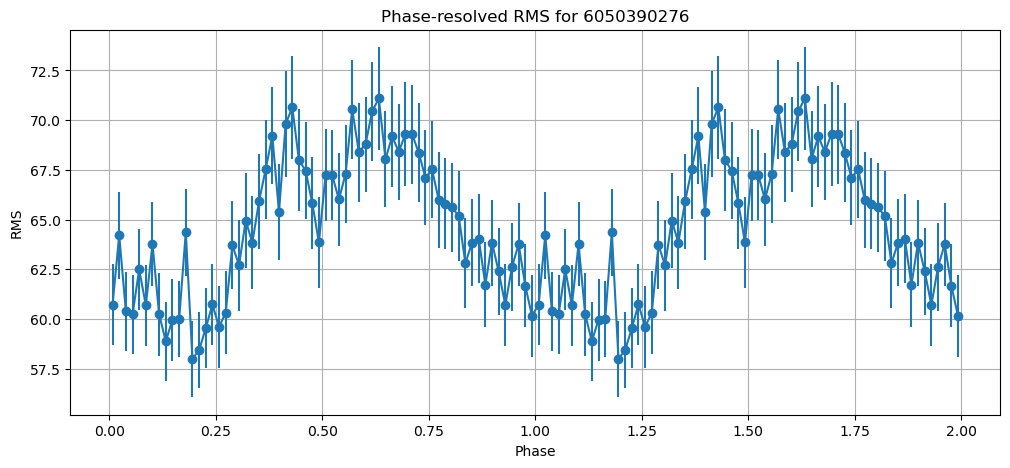

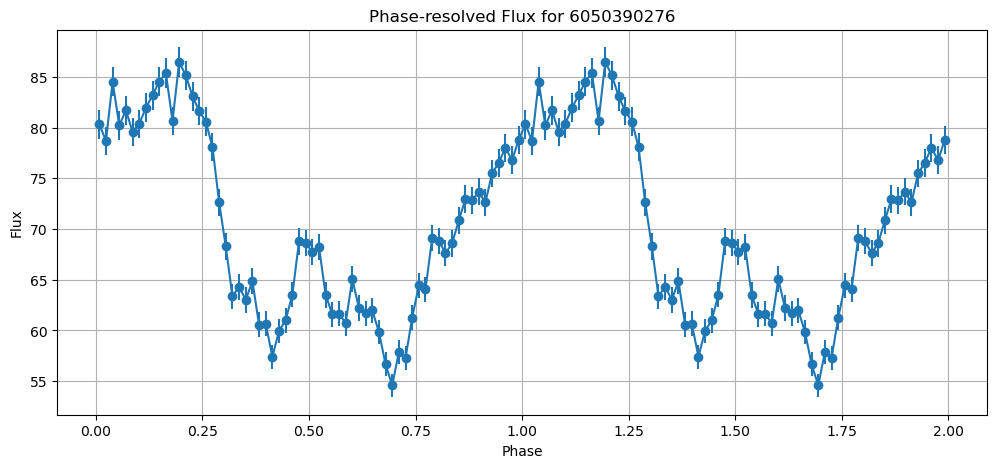

TSTART: 305612000.0
Processing file: 6050390279
First event time: 305612000.0
Last event time: 305634783.95
Total duration: 22783.94999998808 seconds
raw time value: [3.05612e+08 3.05612e+08 3.05612e+08 3.05612e+08 3.05612e+08 3.05612e+08
 3.05612e+08 3.05612e+08 3.05612e+08 3.05612e+08]
converted from reference epoch time:  [3.12760846e+08 3.12760846e+08 3.12760846e+08 3.12760846e+08
 3.12760846e+08 3.12760846e+08 3.12760846e+08 3.12760846e+08
 3.12760846e+08 3.12760846e+08]


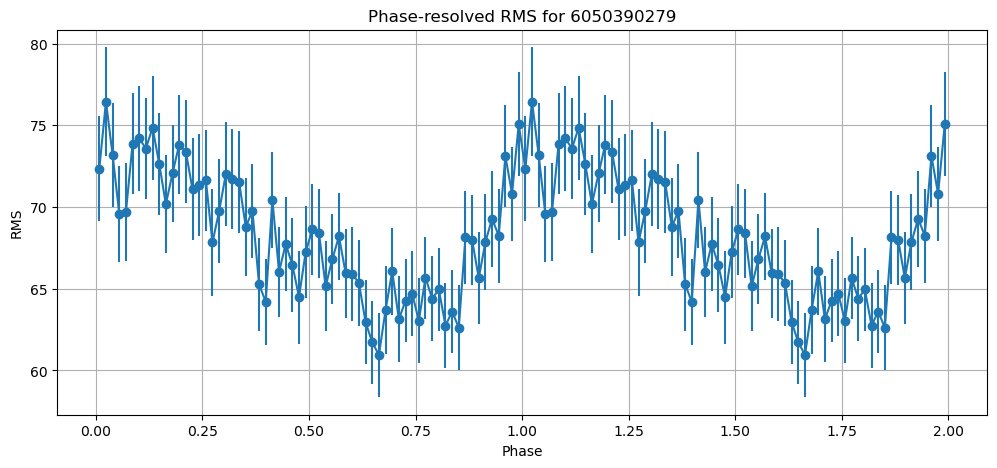

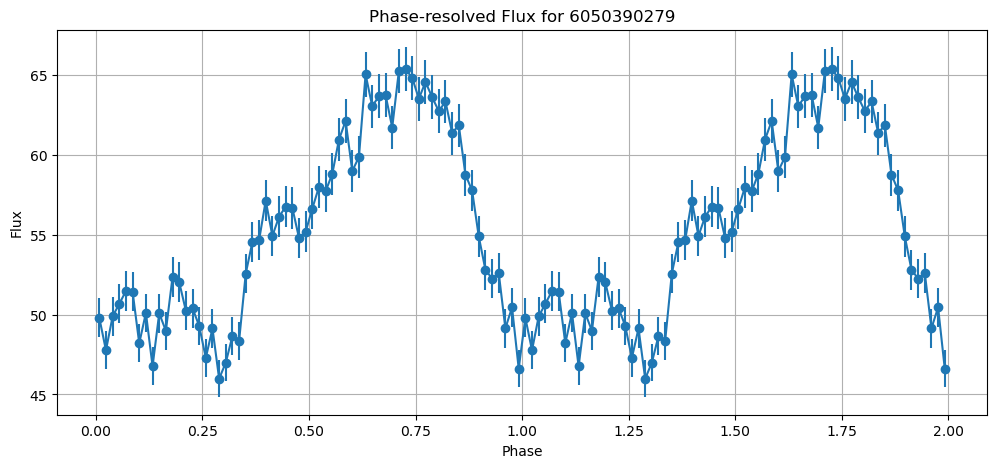

In [6]:
# Run the main function with your input file
input_file = '/home/supremekai/thesis/J0243_6p6124/NICER_second_run/all_lc_periods_manual_error_from_lc_uncor_bootstrap.csv'  # Adjust the path as needed
main(input_file)